In [10]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm


CSV_PATH = "esm35M_500k_neuron_explanations.csv"  
MATCH_STRING = "sheet"           
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 100
NUM_STEPS = 500
A = 5
B = 3

def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))

    print(matches)
    return matches

# ----------------------------
# HOOK + SAMPLING UTILS
# ----------------------------
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# ----------------------------
# MAIN STEERING LOOP
# ----------------------------
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Load neurons to steer
    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    # Organize by layer
    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Store (sequence, activation) pairs

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across all target neurons
        total = 0
        count = 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += h[:, n].mean().item()
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)

        # Save to history
        history.append((new_seq, avg_act))

        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | {new_seq}")

    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Optional: save to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation"])
        for seq, act in history:
            writer.writerow([seq, act])

# Run
steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[(0, 19), (0, 10), (0, 14), (0, 30), (0, 32), (0, 45), (0, 44), (0, 61), (0, 38), (0, 77), (0, 92), (0, 81), (0, 93), (0, 98), (0, 109), (0, 110), (0, 100), (0, 123), (0, 108), (0, 131), (0, 136), (0, 142), (0, 141), (0, 155), (0, 168), (0, 169), (0, 173), (0, 175), (0, 208), (0, 216), (0, 227), (0, 224), (0, 220), (0, 211), (0, 245), (0, 263), (0, 272), (0, 273), (0, 261), (0, 283), (0, 297), (0, 287), (0, 308), (0, 321), (0, 326), (0, 333), (0, 336), (0, 341), (0, 358), (0, 357), (0, 364), (0, 365), (0, 385), (0, 401), (0, 391), (0, 412), (0, 405), (0, 422), (0, 439), (0, 450), (0, 453), (0, 459), (0, 445), (0, 466), (0, 472), (0, 474), (1, 17), (1, 27), (1, 38), (1, 40), (1, 55), (1, 53), (1, 49), (1, 56), (1, 64), (1, 74), (1, 75), (1, 84), (1, 90), (1, 99), (1, 98), (1, 104), (1, 108), (1, 92), (1, 109), (1, 106), (1, 112), (1, 93), (1, 136), (1, 125), (1, 132), (1, 147), (1, 130), (1, 154), (1, 158), (1, 168), (1, 183), (1, 216), (1, 241), (1, 245), (1, 247), (1, 272), (1, 285), 

  0%|          | 1/500 [00:01<10:27,  1.26s/it]

[001] avg_activation=-0.1009 | MNNNNNLNSNYNNNNNYNNNNNNNNNYNNNNYNNMNNNNSNNMNNNNNNNNMNNNQNNXYNNNNNNNNMNNNNNYNFNNNNNSNNNNNNYNNNNNNNNNYNN


  0%|          | 2/500 [00:02<10:07,  1.22s/it]

[002] avg_activation=-0.1037 | NNNNNNNNGNNNNNSNNQNNNNNXQNMYNSNNNNSNYNNYNNXNNNNNNYSNNNYNCKNQNNSNNNYNNNSNNNSNYNNNNNCNXNNNYXNNNNXKNNNNMN


  1%|          | 3/500 [00:03<10:10,  1.23s/it]

[003] avg_activation=-0.0955 | NNNMNNNSYNNNNNNYNNNNNSNNNNNNNWMNNNNCNNNNNNNNNNNAYNNNTYNTNNNNNNNSNXYNMMNNSNXNNNPNNNNMNNNNNNNYNNSNNNNNNY


  1%|          | 5/500 [00:04<05:49,  1.42it/s]

[004] avg_activation=-0.0924 | TNNNSNNNSNNNTNNYNNNNNNYYNNNNNNNNYNNNNYNNNNYNNMNNNNNQNNNSNNNNNNNYNNNNNSNTYNMANNNNNNNNNYNNNNNNSNNSNSNNN
[005] avg_activation=-0.0917 | NYNNNNNNCNSNNYNNNNYNSNNNNNMNNNNNMNYNYNNNTNNNNNNNNNNNNSNNNNNNNNINYNNNNNNYNNNNNNNNNNNMNCYNNNNNMMNNCNNNNN


  1%|▏         | 7/500 [00:04<03:06,  2.64it/s]

[006] avg_activation=-0.0966 | KNNNSMNNNNNNNNNYMNNNNNCNNNNNMNNNNNMNNMNQSNSNNYNNNGNNNNNNNNNNNNNTNNNNNSFSNNNNYNNYNNNNNNNNPYNNNNQNNNNMYN
[007] avg_activation=-0.0981 | QNNNNNTYMNXMNNNQNNNNNNNNNYNNYNMTNNNNNTQNNYNNNXYNNNNNNNNNNNNMNNMYNYNNNNNNNDNSSNNMNNNYNGQNNYNTNNYNNNNNN


  2%|▏         | 9/500 [00:05<01:57,  4.18it/s]

[008] avg_activation=-0.0958 | NMQYNMNNTNNNNNYNNNNNNQLNNNNYNNNYNNMNYYNTYSYNNNSNNNNNSNNNNNNNNNNYNNNNNNNNMNTNNNNNNNTNNKNSNMNNSNNNNMYSY
[009] avg_activation=-0.0987 | YNSYNNNNNNNYNNTNNNNNNQNTNNNGNNSXNNKENNNYSNYNYNNNNNNQXXYMNNSNNNNNNNNNNYMMNNMNNNNSNNSNNNNNNNNSNNNNNNYXS


  2%|▏         | 11/500 [00:05<01:25,  5.71it/s]

[010] avg_activation=-0.0961 | NNNNYNNNTNNNNNNSNYNNYNNNNNNNNNYXNYQKXNNNNMNNNQNNVNNNNYNNNNNNNNNNMNNNMNNNNNNNNNNNNNYYNSNAMNNNNMNNSINNNN
[011] avg_activation=-0.0967 | MXMYNNMNNNNNNNNYNYNNNNNNYNNNNNNNKMTNNYMNNNNNNNNYNNTNNYNNNNQNNNNNNYXNNSNNNNNNNYSNNNNSNNSYNNNYNNYNNNNYNN


  3%|▎         | 13/500 [00:05<01:04,  7.52it/s]

[012] avg_activation=-0.1005 | YNNNYMYYNNNNQYNCQNNNNQNNNNKNNNNNNNNNNNSYNNNNNNQNNNXNNTNNNNXNNNNNNNNNNNNNNNNNSYNNNKNNNNQNANNNNINMNNNAN
[013] avg_activation=-0.0972 | NNNNNTNNNMNNNNMNNNENNYNNNNNNNNNYNNSNNNNSNNYNXMNNNNLNNNNNNNMQNNYNSYQQNNNNNNMNNNNNSNNNMNMNNNNNNNTXNNTN
[014] avg_activation=-0.0990 | YFNNNNNSNNNNNNNNQNNNNNNNNNKNNNYSNNNNNNNYNNNNNNYNNNNNNNYNNYENNNNSNNNNQNNSNNNNNNNGNNYNNMNNSNPNQNNNNFYNMN


  3%|▎         | 17/500 [00:05<00:48,  9.99it/s]

[015] avg_activation=-0.0859 | NMNNYYYYMNNNNNYYMNMXYYNNNYYNMYNNNNNPNNNNYMSSNNNYNNYNNNNNNSNNNNNNYNNNNNNNNTNNNNNNNNNNNNNNNNNNNNNNNNNNNN
[016] avg_activation=-0.0935 | NNNNNNNNNSTNNYNNNNNNNNMNNNNNNNNNNQNNNNNNNNNNNNNNYNNSNYMNPNNNSNNMNNNNNNNMNNYSNNNSNNYXNNQNNNNXNNNNCNNNN
[017] avg_activation=-0.0889 | NMNNNSMNNMNYNNNNNYNYMNNNSYNNYNNNMMNNNTNNVNNNNMNNNNYYNNNNSNNNNSNXMNNNSNNNNNNNNNNYNNNNYNNNNNNNNNNNNNNNEN


  4%|▍         | 19/500 [00:05<00:44, 10.75it/s]

[018] avg_activation=-0.0995 | NYNQNNNYNNNSNNNNNNNNSNNNXYNNNNNNNNKNNNYNXNNYNMNNMNNTNSENNNNNNNNTSNNMMNNNXYNNKLNSNNNNNNNNTNQNNNNNNNNN
[019] avg_activation=-0.0963 | NMQMYMTNSNYNNNNNNNNNNYNNNNSNNNNTSSNNANNNSXNNNNNNYYNNNYNNXNNSKNNNNNMNNNNNYNNNNSMNNQNYNNNSNNNNNNNNNNNNNN
[020] avg_activation=-0.0931 | SYXNCNNYNNNNNNNNNNNNNNNYNNKNSNNYNNYNYNSYNGNANNNNNXNRNNXNNMNNYNMTNNNPNYNNNNNNNNNMNMNNMNNNNNYNNNNNNNYNNN


  5%|▍         | 23/500 [00:06<00:40, 11.67it/s]

[021] avg_activation=-0.1000 | SNNNNNNNNNNKNNNNNGNNNMNYTNNXNNNNNNTNNTNYNSNYNNNNNNNNNNNNNNNYMNNSNNNNPXNNNYNNNNKNNNPNNNNMNNNSSYMSSNNNYN
[022] avg_activation=-0.0957 | YYNNNQSNNNNMNNNYNGNNNNNNNNNNNNNNNQNYNNNMNMNYNSYYNNSNNNCPXNNNYMTNNNNNYNSNNNNNNNNMNNNMYNNNNNNNNYNNSLYNN
[023] avg_activation=-0.0954 | XNXNNYNNXNKNNNNNNCNNTTNNNYNNWMSNNNCNNNNNNSYNNNNNNTNNNYYNNTNNYNNSNNNNNNSNNNNNSNPNNYNYANNNNNEYNNNNNNNNCN


  5%|▌         | 25/500 [00:06<00:40, 11.87it/s]

[024] avg_activation=-0.0967 | SNCXNPNNNNXNNNNNNMNNNYYMNNYYNNKKNXKNNNNNNNNNNNQNNNNNNSYNNYYKNNMMNNNYNNSMNNNYNSNSNYYNNNMNNNNNYNNNNNQFN
[025] avg_activation=-0.0929 | YNANNMYNNNNNSQYNNNNMNNNNNSNNYNNNNNNNNNFNMNNNNNYLMNNNNNNNNNMNNNNNYMNNNNNNMYNNNNNMNNNNNYKNNYNNNXSNNNNYNN
[026] avg_activation=-0.0958 | YNPNNNKNNMNNNNMNNNNMQYMNNNNYNINNSNSNNNNNYNNMNNTMNNNNNNNNYNKNNNNXMSNNYNQNNMSNNSNYNNNYNNNNNNNNNSNYNNYQNM


  6%|▌         | 29/500 [00:06<00:38, 12.21it/s]

[027] avg_activation=-0.0929 | MYNNNNNNMNNNTNNNTYNNNNYNNNNNNNNNNNYSNMYNSMNMNXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNYNYYNNNNNMNNNNCNNNNNNMXYN
[028] avg_activation=-0.0921 | XNYNNNNNNNNNNPNNKNNNNNYNNNQNNNNMNNNMMNNMGNNNYNNSNNSQNNNMQQYNNNMMNNNIMNNNQNNNNMNNYNNNNNCLNNNNNNMNNNNYNN
[029] avg_activation=-0.0895 | MYNNNNNNNNNNNYNNNNYNNNTNNNDNNNNNNNNYNNNNNSNCYNMXNNNNYNNNNYYNNNNNNNSTNSMNNNNNQNNQNNNNNNNNNMNYNNNNNNFNY


  6%|▌         | 31/500 [00:06<00:38, 12.27it/s]

[030] avg_activation=-0.0914 | PYQNNYNNNMNNNMNYNYNNNNTNYSNNNTSNNMNTSNINDENNNNENMNNNNXNNNNNTNNNNYNNNNNNNYNNNYNNNNNNNTNMNNENNSNENYMNNN
[031] avg_activation=-0.0955 | NQYNNNNNNNNNNNNNFXTNNNNNNYNNNMTYNMNNNNNNFMGNNNNNNYYNNNNQMNNNMNNMNSNNNNNNNNNNNNNNNNNNYNNNYNNNNNNNSNSN
[032] avg_activation=-0.0985 | NNNNNNNNXNMNNNNNNMNKISNYNNCNMYMNTNNNXNNNNNMYNNSNNNNRNNNNNNNNXNNNYNNNNNNMNNCMNNPQNMNNYYNNNNPNNNNNYNYN


  7%|▋         | 35/500 [00:07<00:37, 12.36it/s]

[033] avg_activation=-0.0965 | MINNNNNMNNMNNNNNSNNPNNNNNNNNNNNNNNNNNNNNNNNSMMMNNNYNYQXNNNNNNNNNNYMNNNNNNNNNMNNXNNYNNNRNSNNYNNNNNYYYNY
[034] avg_activation=-0.0960 | NYNNMNNSNNNSNNNNNNNYYNNNNNNNQSNNNSQNNNYNYNSMENNSNNMNMNNNYNNNNNNNNNSNNNNMNNNNNNNMYNNMNNNNNNYMQYNNNNNSNN
[035] avg_activation=-0.0956 | MMMNNNNNNSNNNNNNSNNNMNMNNNNNYNNNNNNNNNNNNNNNNNNNXNNNINMNNNNNMNNMNYNYNSNNFNNNMNNNNMSNLEYMNNNMNDNNMMYMYN


  7%|▋         | 37/500 [00:07<00:37, 12.43it/s]

[036] avg_activation=-0.0940 | NNNNMNNNNNMSNCNYNYNNNMNYCNNKNYNNNNMYNNNNNNNNTNNNXNQNNNNNNNCNNNXNNYNMNNNNMNNNNNNYNNNNNNNNNNMYNNNNNYYNNY
[037] avg_activation=-0.0820 | MNXNNNNMYNNNFNNNYQNNNNNNNNNNNYNNMMNNPNYNNNNNNNLNNNNMNNNNNNNNNNNNNNNNNNNNYYNNNNSNNXYTYNNNYNYNNNNNNNYNNN
[038] avg_activation=-0.0953 | NMNYNNYYMSNNNQXNNNNNYNNNNYNNNNYNNNNNMNNNNNYNNNNNNNNNNPNCNNNNNNNNMNNYMNNNNNNNMNNNNNNKMNNNNNNNNNMNNNNNNN


  8%|▊         | 41/500 [00:07<00:36, 12.46it/s]

[039] avg_activation=-0.0967 | MCNNNNNMNGSNDNNYYNNNNNNNNNSNNNNNNNNNNNYNNQCSNNNXSNNNMNYNNNNNNNNNNMNNNYTSNNYNNYNMNNNNNNNNNYNFYNNYNNNYY
[040] avg_activation=-0.0931 | NNNNMNNNNYQNMNNNNNNNNNNNNMNNMNRNYNNNNXYNNNNNXNNYSNNNNNNYNNNNNNNNNNMNNYNNYMNNNNNNXNNNMNNSNYNNSNNNNNMNNN
[041] avg_activation=-0.1009 | SNNQNNNNVNNNNNNNYNNXYNNFNNNNYNKNNNNNNNNNDYNNNXNYNNNNYNQNNHYNNNNNPNNNNNYNNYNANNNNNNNNNYNNNYNNMNNNNNNSN


  9%|▊         | 43/500 [00:07<00:36, 12.56it/s]

[042] avg_activation=-0.0952 | YNNNNYMNNNYNDNXNNNNNNNSNNMYNNNNNNNMNINNTNNSNNNSNKNFTNNNNNNYYNNNQNNNNNKNQNNNNYNNNMNSNNNTNNTNSNNNNNNYMNN
[043] avg_activation=-0.1008 | NNMNNYNNNYYNTNYNNNNSNXSNYNPYNNNNYNNNNNYNNNQNNNNNNNSNYNNNNNNSNNNNNNNSSMNNNNNNNNYYNMNNNSNNNNXXYNNNNNNNN
[044] avg_activation=-0.0960 | MNNNNMNNNSNNNNNNNYNNQNNNNNKXNMNNNNQNNNNNNNNNSNTNNNSNLNNNNNSNNNNNNNNNNMYNNNNMNNNNNAKNNNNNNNNVYYMNNNNNNN


  9%|▉         | 47/500 [00:08<00:35, 12.60it/s]

[045] avg_activation=-0.0938 | NMNNNNNNSNNNYNNNNMNNNNNNYSYNNNNNYNPYNNNNNNNNMNNNINNTFNNNNYNQNNNNNNNNNNNTSNNNNNNNNNNKNNNNNYNMNNSNNNNNN
[046] avg_activation=-0.0965 | NNNNNNMKNNMNNYNNGNNNNNNNSQNNNNNNNNNNNXNNNKWSMYNNTNNNNNNMXNGNNNSYNNNNNNNNPNNMYSSNNNLNNNMSNSNNNNNNNNNN
[047] avg_activation=-0.0941 | NSNNSNNNSNSNNNYMNNMYYNNNYSNNSNNYNMNNNKNNNNYNNYNMNNNNNNNNNNNNKNNNMNMNMNNKNNDNYNNNNNNNNNTNYYNNQXMNNNNN


 10%|▉         | 49/500 [00:08<00:35, 12.63it/s]

[048] avg_activation=-0.0955 | NNNSNNNNNNYNNYNNQNNNNQNYNYNSDYNNMNNNYNNNNNNSNNNNNNNNNNNNNNNNNYNNYNNTNNNYNNYNNNNNNNYNNNNMNTQYNNNNNNMNQN
[049] avg_activation=-0.0998 | NNNNNNNNNNNNNNNNSNNNMNTNNXNYNNVPNNNNANYNNNNNNNNYNNNTNNNSNNCNNNNNNYNNNYNNNXTNMNSNNNNQNNNNNNCNNNNNNNMNNY
[050] avg_activation=-0.0952 | MNNNNNNNNXNNNYNNNNNNNNYTSNQNNNSNNYNNCNNNNYNSMNNNPNYYHNNQMSNNNNYYNNMYYNNNNYNNNMNNNYNNMYYNNNNNNNNNNSNYNN


 11%|█         | 53/500 [00:08<00:35, 12.70it/s]

[051] avg_activation=-0.0949 | MSNNNNXNNKNNNNMNNNNNNNNNTNNLYNNNMNYNQNNPNTNNNFNNNYNSNNNNNNNYYNNNMMNNNTYNYNNNNQNNNNNMNNNYXNNNNNMNYNQNX
[052] avg_activation=-0.1015 | NXNNSYNNQNNMNNSNNNSNNNNSNNTQNNNNNNNPNNSNWNNYNNSNNNYNNYNNNNTTNQQMSNMSNNNNNNNNNNNNNNNNNNXYMKQNNNNNFNTNNQ
[053] avg_activation=-0.0992 | YNNMTNNNYANNNNNMNNYNNNNNYNNNNMSNNYNNNTYTNMNNYNNNCSNTNNMXSNNNNNNNTNNNMNSNNYNNNNNYNNNSTNNNNNNMNNSNSNNNNN


 11%|█         | 55/500 [00:08<00:35, 12.64it/s]

[054] avg_activation=-0.0942 | NNNNQNNNNNNNNMNNYMMYSYNNNYNYNNXYNNNNNNAMNNNNNNNNNNNNNYGYNNNNNYNYNNNXNNNNNNNNNMNNNNINSNNNNNNNMQNNNNNMN
[055] avg_activation=-0.0915 | MNYNNNNNNDNNNYNNNYFNYNNYNNNGYSXYYTNNNNNNSNNNNNNNNNMNCNNNNNNMQMNSNNTNNNSNNMNPNNMNSNNNNNYYYNNNNNNNNNNNTN
[056] avg_activation=-0.1027 | MYNNNNNXMENNNMNSNSNNNXXNNNNTNYNNNNNNNNNNNNNNNNNNNNNNGNNNNNMNNNNNNNNNXNNNNNMNMNNNYNNNXNNNNNNNNNNNNNNNNN


 12%|█▏        | 59/500 [00:09<00:34, 12.69it/s]

[057] avg_activation=-0.0847 | YNMNNNXNNXMYNSNNNNNDSMNNNNNNNNNNNNNNNYNYNQKNNNNNNNQMNXNNNNNNYNMYNNYSNNNNQNSNNNNNNNNNNNTNNSNQMNDNFNSNXN
[058] avg_activation=-0.0962 | NNNNNLNXNNNNNYNNNTNNNYNYYYYNNNNYNNNNQNNMNNNXNNNNXNNNNNNNNLNYNYNNSYNNNYNNNSNNYNNNNFNYNNNNNQYNQNNNNNNNNN
[059] avg_activation=-0.0889 | YNNSYNQNANMNNNNNMMNNNYXNNNMNTNNNNNNQNNMMNMNSNNNNYNNMNNNMGSXXNNTNNNNNYNNNNQNNPNNNNYNNNNNNNNNNNNNPMYNMNN


 12%|█▏        | 61/500 [00:09<00:34, 12.64it/s]

[060] avg_activation=-0.0937 | MNNNNMNNMNPNYNNNNNSNNNYNNNNNNNMNYNQNNNNNSNNNNNNNKNMSNNNYNANNNNNNNNYYNMNNMTNLNMNYNNNYNSNSNNNLNNNYNNXNNN
[061] avg_activation=-0.0986 | MYMNNNNNNNMNMNYNKNNNYLNYNNYNYTNNYNNNSYNNQNNNNYSNNNNNNNQNNNNNNYNNYNYNNNNNNNNNNNNNNSNMNNNXYNNSNNNNNNNNNN
[062] avg_activation=-0.0975 | NXKNNNNNNNNNNNYNYNNNNQNTNNNNNNNSNQNNPMTNNNNNVYNYNNXCNMYQMYTNNQGNNNNNNNTTNNNNSNNNNNNNNYNGNNPQNNTNNNNNNN


 13%|█▎        | 65/500 [00:09<00:34, 12.64it/s]

[063] avg_activation=-0.1017 | XYNNNSNNNSYNNNNMTNNNNANNTNNNNYNMNNNNNNSNNNNNNYNNQNNYYYNYNNNSNNNYNNXNNNNXNNNNNMNXNTPYNNNNNNNSMNNNNYNNNN
[064] avg_activation=-0.0959 | NNNQMNYTNNNNYNXNNCNNNNNMYNGYNXNNNNNNNNNNNNSNNNNNNNNMYNNNNNNMNNYNNNNNNNKNNNNNNNNNYNNMNKNXNNYNNNNXNMNNNN
[065] avg_activation=-0.0972 | NNNNNMNNNNNNNYSMNQNNNNNYNNNNNNNNMMNNNNYNNNNNNNGMNTNNNNNNNNYMYNNNNNENYNNNNNNNNNNNNYNMYNNNMNNNNNNYNYYKNN


 13%|█▎        | 67/500 [00:09<00:34, 12.73it/s]

[066] avg_activation=-0.0877 | XNSNXNYNNNNNNNNNNMNNNYLMNNSMNSNNNNYNNTNNNQNNNNNNNQPNNNNNNNNNCPYNNNNSNMNYNNQNNNNNNNXNNXXXNNNYNNNSYNNN
[067] avg_activation=-0.0974 | NNTNXNNYNSNSNNCNYNNNYNNSNNYNNNNNNNNSNMNNNNNNNNNNNNNNNNNNNNYNNNMNYNNSNNSNNNNNNNYYNNNNYNNNNNSNNNNNNNYNN
[068] avg_activation=-0.0970 | NPNYNNNGNNNNYDYNNENNNNSNNYNYNNNNNNYMMYNNNYNNNNNNNNYNSNNNNNNNNNNSNNNNTNNNNNNSCNNNNNSMNNNYNNNNSNNNNNNGYN


 14%|█▍        | 71/500 [00:10<00:33, 12.74it/s]

[069] avg_activation=-0.0923 | NNNNNQNYNNNNNNNYNCNNNDYSNNNNNNNNYNNNNNQNNNNNNNNNNNNNNNNNNYNNNNXMNNNYNNSNNNNSNNCNNNNNNNNNNANNNNNNNNSNNN
[070] avg_activation=-0.0863 | MNQNNNNNNNNMNMNNMMMNNSNNTNNNNNNKNSNNNNNNYNNNMNNMNNNMSNSNNNNNNMNNNNTNNNNNQNNQNNNSNNSYSTNNNNNNNNNNYSNNN
[071] avg_activation=-0.0979 | XXNNNNMNNLNNNNMNNNNXNYNNNNSNTNNXNNYYYNMNNYNNNYNMNNMNTNNNNNNNNKNNNNQYNNQNNNNNNNNNNNNYNNNNNNNNNNNMNNENNN


 15%|█▍        | 73/500 [00:10<00:33, 12.67it/s]

[072] avg_activation=-0.0986 | ENSNNXNNNSYNMNNYNNNNNNNNNNNNNNNSNNNNMSNXNMNNNNNQNNYNNNNNNNNNYXNNNNNNNNENNNNNTYNNYQNNNNNNQYNMTYNNNNMNXN
[073] avg_activation=-0.0910 | NNNNNNNKNNNYNNYNNNNXMYNNNNNNYNNNMNNNNNNYNKNNNMNNNNNNNNNNNNNNNNKNNNNNNNNNNNNSNQNNNNSNNNNNYNNMXTYNNMMNA
[074] avg_activation=-0.0918 | NNMNNNNNNSNYNNNNNYNNNNYNNNNNSNNSNNSMNNNNYNXNNNNNYNTNNNNNNYNNNNNNNNKNNNNPNMNNNXNNYNNNGSNNNYNNNNNNNSNNN


 15%|█▌        | 77/500 [00:10<00:33, 12.67it/s]

[075] avg_activation=-0.0993 | NMNNXGNLNNNNNNNYMGNNNNNNNNNNTNYMXNNNNMNNNNNXNNNNNNNNMNNNNNNNNNNYNNNXMPNNNDDNNNNNNNYMNNNYXNDYNNYMNNNQNN
[076] avg_activation=-0.0940 | YNNNNNNNNNNYNNMNNNSNYKNNNNNNNNNMNNNNMNNNMNXNNNTNYNNXNNNNMNNNNNNNSNNMNNSYNNNYNNNNNNGYNNNXNMNTNNMTNNNNN
[077] avg_activation=-0.0948 | SNNNNCNNNNNGNNQYNNYNNNNNYNNNNNNNNNNYYNQNSNYNNSYYNNCNNNNNNNNNNNNNNNNNNNQNNNNYNXNNTNNNNNYNMNNNMNYNNYYNNQ


 16%|█▌        | 79/500 [00:10<00:33, 12.56it/s]

[078] avg_activation=-0.1000 | MNTPNSNYNNNNNNNNNNNNNYNMNMSYNSTNNNNNNNNNYNMMNNNNNYMNNYNNYNNNNNNYNTNNNNNSNNNSNNNNNNNNNXNNNNNNMSYNNPNY
[079] avg_activation=-0.0985 | NYNYYNYNNNYGSLNNNNNNNNNNMNYNNNYYPNXNNNSNNNNNNNNNYYSNNNNYNNNNYNMNSNNNYMSNNNYNMNNNYNNNNNNNMNSSNPNNNNNNNY
[080] avg_activation=-0.0967 | QNNNNYYNYSNNNNNNQNNYNNPNNNNNNNNNMNNNTDSNNNNYNNNNGNNNNKNNNMNNNNXNNSMNYNMNNNSXNNSNNQNTNYSNNMKNNNNQNKNNNN


 17%|█▋        | 83/500 [00:10<00:33, 12.59it/s]

[081] avg_activation=-0.0951 | NNNNNNNNYNNNYNQYANCNNNSNNNNNSYNNNNNXNNMNNNNTNMNNNNKRNNNNNMNNNNNNNNYMNNSNYNNSNNNNNNMNNNNNNNNSNNNNNSN
[082] avg_activation=-0.0989 | NNNNNNNYNSNNNTNNMNNNNNYSNNCNNNMNNNNNNNNNNNDNNNNYNSNNNNNNNNMSNNNTNNNNYNYSMNDNPNYNNNNYNNNENXNQNNNNNNXNNN
[083] avg_activation=-0.0909 | YNNNNNNNNNCMTNYNNNNPNYNNPNNYNNNNYSNNNNSYEPYSNXYNNNNNNNSNNNNYXYNYNNNQYNNNNYMNYNNNNNNNNNNNNNNXNNNNXNNMNP


 17%|█▋        | 85/500 [00:11<00:32, 12.61it/s]

[084] avg_activation=-0.0981 | NNYNNNNNYNNNNNNNNQNNNNNNQNNNSQNNNNNNSNNNNNMNNNNNNNNNTNNNYGNNCNSNNNNNNNGNNNMMYNNNNMTMDNNYQNNNNNNNYNNXNN
[085] avg_activation=-0.0887 | YNNYNNQXMNSNNNNMYMNYNMNNNNNNNNNYYNNYYNNNSNNNSNNNNNSNNNNNNNNNNYMNNNNNTNNNYNNNNNNNQYYNCNYYNNNNNNLDXMYQNN
[086] avg_activation=-0.0989 | MNNNNYNNQNNNNNYNNNNQKXYNNNSNXNQNNNNNNNNITNNNNNNNNNNNNNNNNNXCNYSMNNYNNTNXYNNNNMNNNYNNNXNNMNNMNNANNANNNN


 18%|█▊        | 89/500 [00:11<00:32, 12.66it/s]

[087] avg_activation=-0.0917 | NSNXNNNNXNNYNNNNNNNNNPYNNNNNNNNNYNNYNNNNNNTNYNSNNYNNNNNNNNNNPNMMNNCMNNMNYYXNYNNTNNNNNNNNNNNNNNYNNNNNN
[088] avg_activation=-0.0949 | NNNNPNNMNNNNNNNNNQNGNNNNMNNNNNNNNFTYNNNNNNNYTNNNNNNNYNNNNNYNNNNNNNNNNNNNNNNYNNNNNNMNANTNNYSNMNSNNNNQNN
[089] avg_activation=-0.0960 | NNNNYNNTNYNNYKMNMQNXNSNYYKNNNNNMQNSYNNNNNNNNNNNNNNNNNMNNNNNNNMQNNNMYNNNNNNYNDNNMNSNNNNYMMSNNYNYCNSNNNN


 18%|█▊        | 91/500 [00:11<00:32, 12.64it/s]

[090] avg_activation=-0.0890 | NYYMNNYNNSNNNNNYNNYNNYNNNYSNNNYNNNSNQNNNNNYNNNNNNNYNNNNQNNMNNNNYNNNTYNNNNNNNYNNNMNNPNNNNNNKNNNNNTNNNYS
[091] avg_activation=-0.0954 | YNNNNYNNNTCNSNNSNSNNNNSNSNNNNNNNNNSNNSNXNNNNNNNNNMNNNNNNNNNNMNNNNNNNNNNNNNMNMNDNYNNNNNTNNNNNNNYNNNSNMQ
[092] avg_activation=-0.0928 | SMYNNNSNNNNNKNYNNNNNNNNNYNYSSNNSNNETNNNNNNNYNNNNNNTNYNNNMNMNNNNNNNNNAMNNNNNNNYNNSNNNNNNNQNNNNNNYNNNNNN


 19%|█▉        | 95/500 [00:11<00:31, 12.66it/s]

[093] avg_activation=-0.1008 | NMSTYNNNNQNKYNNNYNNNNNNNNNNYYNNNQNNYNNNNNNXNYNNSNNYMNMNNNSNNNNXNNNNNNNNMNNNNNNNYNNANNSNNNNNNNNNNNNNNYN
[094] avg_activation=-0.0934 | NNNKNYNNNNMNNNQNNNNNMNNYNNNNNNYNNNYNCNNYNNNNMNNNNNNNNNNNNNNNNNNNNNNYYNNNNNNNNSNPYNYNSNNNYSKNNSNNNNNNN
[095] avg_activation=-0.0912 | MMSYNNNNMNNGNNYNNNYNNNMNNNNNNNNNNYNNNXNNNXNYNNNNYNNNNNNNNNQNMNNXQNNSNNNNNNYYNSNTDNNNHNNNYMNSNSNNNNNMNN


 19%|█▉        | 97/500 [00:12<00:31, 12.63it/s]

[096] avg_activation=-0.0988 | DNNNYNNNNNNMNNYNMYNNNNNNNNYNNNNNNNYNNKNNNNNNNNNNNSNNNNNNNNNYSNMNASNNNNNGNNNNNNNYNYNNNMNNYNNNMNNYNNNNYN
[097] avg_activation=-0.1073 | NNNNNSNNNNNNNNNNNKNNNSNYNNNNNKNNYYNNNNNSNNNNYNNNNNSNNNNNNNSNNNNXTNNNYNANQNNNNMNNNNSYNNYNNNNNMNLNNNTYN
[098] avg_activation=-0.0958 | NNNNNNNNSNNYNNNNNYNYNYNNNNNNNSMNTXNNNNNQNNMNMNNNNNNNNYNNMNNNMNNNNYNNNSNNXNNNNNNXNKNYTMHNNNYNYNYNSSYQY


 20%|██        | 101/500 [00:12<00:31, 12.64it/s]

[099] avg_activation=-0.0980 | NNNNNNDNNNNNNNNTGNNYNYNNNNYNNNYNNNNYNNNNNNNNNNNNNNNNNNNYNYNNNNNMSNNSNYYQNNNNSNMNNNNNNNNNNSMMNNNNNNSNNN
[100] avg_activation=-0.0893 | NKKNNNNNNNNYNMQNNNNNNNNNNNNSKNNNYNNNWNNNNNNNNGNNNYNNNNNNQNNENNNNNNNNNNNNNYNNNNNNNNNNNNNYNNNNNMNYSSYNNN
[101] avg_activation=-0.0978 | NNNNNNXMYNSYNNNNNSNYNYTNNNNINQNNNNSNNMNNNMYNYNNNNNYMNNNNNNNNTYNSNNSMNNNNNNNNDNNNNNNQNNNYNYMSNNNYQNNNSN


 21%|██        | 103/500 [00:12<00:31, 12.61it/s]

[102] avg_activation=-0.0870 | NYNNYNNNNNDNNNMNNNYNNNYNYNNNNNNQNNNNNNTNNNNNNNNNNYNNXNYNNNNMNNNSNNNNNYNNMYNYLNNTYYNNNNNNNNNYNNNYCNNSTN
[103] avg_activation=-0.0990 | INNXYNNNNNYSNYQNNLNNNNNMNMNMYNNYXNNNNNNMASNNNNNYYQNNNNNNNNXQNNNNNSSNXNNNSNMNNNNNNNTNKNNYNNNNNNNNQNNNNN
[104] avg_activation=-0.0970 | NNMNKNNNYYYQNNNNMNWNMNYTYNNNNNNPNNNNNNSNNNNNNNSNNMNMNNNNYNNNXNMNNNNNNTNNMSNNYKNNNYTNNNNNYNQNNNSYNNNNY


 21%|██▏       | 107/500 [00:12<00:30, 12.70it/s]

[105] avg_activation=-0.0968 | YCCNNNNNNLNNNNNNNNNSNNNNYYNNTNNNNNNNNNNNNNNNNTNNYXNNNNNNNNNNNNYYNNNSNNYNFFNTNSNYPNNNNNNNNNTTNSNNNNNGYY
[106] avg_activation=-0.0980 | MMNNSNNNNNYNXYNNNNYNNNYYNNNNNYMQYNNNNYNNANNMNYNCNNNNNSKNNNNMCNNNNNNYYNNXMMNNNYNQNENNNNNNMNNNMNNNMQNN
[107] avg_activation=-0.0989 | NTNNNTMMYNNNYNNNNNANNNNNKNNNNNDNMNNNNQYNYNSNNNNNNNNNISANNTSNKNNNNNNNNYTNNYNSNNYNSTNNNNNNNNNSSNNNNNNCQN


 22%|██▏       | 109/500 [00:13<00:30, 12.67it/s]

[108] avg_activation=-0.0917 | MNNNNNNYNNNNNYNNNNYNSNNSNNNNNNNNNNNDNNNNNNNXNNKNMNYNNNNNNNNSNNMYNYNNNMNNNSNNNYNNSYMSNNNNNNNNNNNXNNQNNN
[109] avg_activation=-0.0876 | NNNNMNNNNNYNNNNNNNNNNNNNYNNDKNNNNXYNNNNNSMNNNYNNNNNXNYNNNKNNNNNYNYNSNNNNNNNNTTNMNNNMSNYNPYNNTYQNYNNNN
[110] avg_activation=-0.1041 | NNNNQYXNNNMNNSNNNNXNNNNSNNNNNNMNQNNNNNNQNNNYQNNNYSNNYNMNYNNNYXNNNNYMNNSNNNNNNNSYSYNNNPSMQNNNSYNNYNNMFS


 23%|██▎       | 113/500 [00:13<00:30, 12.66it/s]

[111] avg_activation=-0.0959 | NNNNNNNSNNNNNSNNYYNSNMNNNNNDYNNNNNNNNNNNSYNMMNNNNNNMNNNNNNNNNNNYQSNNTKYNNNNNNNNPNNNNNNNNSNNNNNNNNNNYNY
[112] avg_activation=-0.0936 | NNNNNNNNQNNSTNNNNNNNNNNSYNNNYNNNMNSNYNNQYNNMXNNNNYGNNNNNNNNQNNNNYNNNYNNNYNNNSNNNANSNNNNNNNNNNNNNNNNNNN
[113] avg_activation=-0.0900 | MYNNNNNNNNNNNQNMNNNPNNCNNNNNNQNNNNNNNNKNYNYNNNNNNNNNNNNNNNNYNNYNNTMNNYMNNNNNNNNNKYNYNNNNNNNNNNNNNNYNN


 23%|██▎       | 115/500 [00:13<00:30, 12.67it/s]

[114] avg_activation=-0.0942 | NMYNNNNNNNYNNNNXNNNMTKNYQQNNNYNNNNNNNMNKNNNNNNNNYNYNNNNNNQNNSMNNNNKNNNNNNNNNNNSNYNPNNTNNNNPNNNNNNYNNNN
[115] avg_activation=-0.1001 | NNNXNNNNMNNNDMNNNNMXNMMNNMNNQSNFNNMNNYNNNYNNNSNTNNNNPNKTNNNNNNNNNNYNNNSNNNNNNCMNNNNNNNNNNYMYNNNNNNNNNN
[116] avg_activation=-0.0927 | WMTNKTYNNNNNNNNTNNNMNNNNSSYYNNNNNNNNNSNNNNNNNNNNNYNNNNMDMDNMNNNNNNSNYMNNNNNYNNNNNNNNMNNNNNNNYNCNMYNQYY


 24%|██▍       | 119/500 [00:13<00:30, 12.61it/s]

[117] avg_activation=-0.0848 | MPNQNNNNNNNNYNNNNYNNNNQYNNNNTNNYNNNNNNYNQNYNNNNNNNNNNYXSNNSNNNNNNNQNNNSXNNNNNSNNNNNNYNMNMNNNNNSNYSNNYN
[118] avg_activation=-0.1046 | NNNMNKNNNYNTNNYNNNNNNNXYNNNNMNNNSYSNKNNQMNNNYNNNNNNQNNNMNNNSNNNNNNNFNYNYQNNNNNMDNNNKNNNMFNNNNNNNYKNNNN
[119] avg_activation=-0.0961 | MNNQNNNYMNNYSCNNNTNKNKNSNYNNNXNNNSNNNYPNNYNNNNNNNNNNNSNNNMNNNNSNNNNNNNYNTMYNYNNNYNMTYNSYXTNNNNNYMSNNNN


 24%|██▍       | 121/500 [00:13<00:30, 12.55it/s]

[120] avg_activation=-0.0952 | NNNNSNNTNNNNNNNNNMYYSNTNNNNNSNSYNNNNNNNNYNNNNNNNNNLSNNNNYNMNNNNNNNNNNSNMNNNNXMYNXNNNNNNYSNNNNNXDNNXNNN
[121] avg_activation=-0.0980 | NYNNNNNNNNNNYQNNNNNNNNYNNNNXNNNNNXNNSYNNTNNYNNNXNYCNNTNNNSNYNNNNNNNNEQNNNCNSNNNNNNYNNNNNNNNSNNNNNNNNNN
[122] avg_activation=-0.0945 | QNNSNNSNNNYNNYNNNNNNYNNMNYYNYNNNNNNSNNNNNNENNNNNNYNNNMNNNNYNNNNNYYNYTNSNNNNNHSXNNNYNNNNNNNNNNNYXNNTYAN


 25%|██▌       | 125/500 [00:14<00:29, 12.65it/s]

[123] avg_activation=-0.0991 | NNTSNSNXXNNNNNNNNNNNNXNNNNYKNNNNTNNNNNNNNNNNNYNQFNNNNNNNNNNNNNYNNNNNYSNNNNXYQXSNNNNNNXQNNNNNNNNNNNXNN
[124] avg_activation=-0.0894 | NNYNNNNNNNNTNNNNNNYQNNYNNMNNYNNNNNNQNNYNNNNNNNNNNNNNNNNYYTYNNPNYNXNMMNNNNNTNMXNXNNNYNTNNNNNNNNNNNNQNM
[125] avg_activation=-0.1016 | QNNNNMNYNFNNNNNNNCYNMNNYNNNNMNMNNMNNQNNNNNSNNNNFNNSNNSNNNNNQKNYNNNNSNNPNNNNANNNNYMNNNENNNNNNYNNNNSNNNN


 25%|██▌       | 127/500 [00:14<00:29, 12.68it/s]

[126] avg_activation=-0.1031 | NNNNNNMNNNNNNNNQQYNXNYNNYSNNNNNNYNMNNNSNNYNNNNNNNNMPSNCNNNMNNYNNNNYNNNYXQNNNMTNNYNNNMNNNNNXMNNNNNNNNNN
[127] avg_activation=-0.0945 | MNSNNCNKNGNNNNKNNNNNNNNFTNTTNNMNNNYNNENNANNNNNNNNNVNNPNSNNNNNNNMNNNNENYNNMNNNYNNQNNNNCNNNNNNTNQANSNNNN
[128] avg_activation=-0.0911 | CNNNNCNNNNYMNNNNNNYNYNNNNNSNYPNNYNNNNNNNNNYMNNNNNNNNNNNNNNNNNNNNNNYNNNYNNNNNNNNNNYNMNNNNNNNNNNNNNYNNNN


 26%|██▌       | 131/500 [00:14<00:29, 12.70it/s]

[129] avg_activation=-0.0963 | NSNNNNNNXYNQNNQNYNNNNNNNNNNNSNNNMNNNNNNNNNNYNNMYNNNNNNNNYNYNNNNSNNYNNNNTSNNNNNNYNYNNNNGQNMNNNNNNNNNNKM
[130] avg_activation=-0.1024 | YNYNNNNNNNNNNTSNNNNNNKNNNNSATNNNNNMMNNYNMNNNAQNNYTNXNNNNMNNNNYNMNNNNNNNNNNNNNGMNNNNNNNSNQNNSNNNNNYNNNN
[131] avg_activation=-0.0945 | NNNNNNNNNNNNNNNNNLNNNNYNYYYNNNNNNNNNNMNNNYNNNNKXNNNNNNNYNNNYNQNNNSKYNNNNNNNQNNNNYSNYYNNNNNNNKNNNNNNNSI


 27%|██▋       | 133/500 [00:14<00:29, 12.65it/s]

[132] avg_activation=-0.0977 | SNNNNNNYXNNNYNNYNMNMNYYNYNNNNYNNMNNYNNNNNNNNNNNNNNQNNTTNYNYNNKXNNNNNNNNSNYNNYNNNXNSNYQNNNNNMNINTNNNNNN
[133] avg_activation=-0.0969 | MNNPNNNSNMNYNNNCSNNNNNNNNNNNNNNNNNTNNNYNSNNNTYYYNNNNNYNNNYNNNNNMNMNNNNNNNNNNYYNNNPNNNNNNNYNNNXNNNYNYNY
[134] avg_activation=-0.0927 | NMNYMNLNNYNYNNNYQNNNNYRNNMSQNNNXNYNMNMSNNNXSNSNSYNNNSNNNNNNSMCNMNNNMYENNYNYNNMNNNNNNNMNNSSNPNNNNNNNN


 27%|██▋       | 137/500 [00:15<00:28, 12.61it/s]

[135] avg_activation=-0.0994 | YSFNNNNNKNNNMNNCNXNNSYTNNNNNNSNYNNNNTNTNYDNNSNYTNYEQNNYNNQNNSSPNNNNNNNNSNNNNNNYNNNNNNNNNSNNNNYNTSNNSNY
[136] avg_activation=-0.1030 | MNNNSNNNYENYNNNNNNNNTNNNNLNYNNNNNNNNNNYNNNNNXNNNNNMNNNNNNNNMTYLQQNSNNYNLMYYNNNNNNNNNNYNNMNNNNNNMYNNMNN
[137] avg_activation=-0.1014 | YYNNENNNNNNNYTYNNNNMNNNNNNNNNNYTNNSNTSNNNNSNNTNYNYNNNNNNYNMNNNNXNNDNTNXNXNFXSNNNNNNNNPNSHNNNCNYXYNNYNN


 28%|██▊       | 139/500 [00:15<00:28, 12.54it/s]

[138] avg_activation=-0.0974 | SCNNNNNNSNNMNNNNNNMTNNSYNNMNQNNNNNNNNNNSMNNNNNNPNNNNNNNYNNNNNNNNNNNNNNNNXMNNNNNNYNNMNSNSNYNNNNMNNYNNY
[139] avg_activation=-0.1067 | MNNNNNNNNNNNNNNNNNNYNTNNNNNNNNNMNNNNNNNNNNXYNNSNNNNNNNYNNMNMNXNNNMNYNNNNNSNSNNNNYQMNNNNMNNNNNXQNYNNMNN
[140] avg_activation=-0.0998 | SNYYNNNTTMXNMNNQNMYNNYNNNNNMYNYNNNNNPMNXNMNNNNSQSNNNYNNNNSNYNYSNNNNNNSMNNMNNNXSNNNNNNMNNQNNNNNNGNNNMNT


 29%|██▊       | 143/500 [00:15<00:28, 12.68it/s]

[141] avg_activation=-0.0892 | NNNNYNNNNYNNNNYNNNNXNNNCNNSNNNNNNFNMMNNNNNNNSYNNINNNNNNSNNNNNNNNNQNNNNNQNNNNNNNNTNNNNMNNNNNMQNQNYMNNN
[142] avg_activation=-0.0949 | MNMNNNNLYNNNSFQNQNNNNNNSYNNNPNNNNNTNNNNNNNNSNMNNNLNYNNNNNNNNNYNNNYLNNNSYNNMNNYNNNNNNNNNYNNNNNNNYNMNNNN
[143] avg_activation=-0.0945 | NNQNNNSNNNNNANNPKNNNNNMNNNNGNMNNNNNNYNYNNNNNYYNNNNNNYNSNQNNMNNXYNYNNMYNNYNNNNSNNNNMNNNYYNNNNNNNNNNMNN


 29%|██▉       | 145/500 [00:15<00:27, 12.70it/s]

[144] avg_activation=-0.0980 | NSKNNNNNNXNNNNYNNYNNNNYMNNNXNNNNNNNNNNNNNYNNNNNNNNYNSNNANTYNMNNNMNNYNNNKYNXNSNNNYNNMNNNNYNNNTNXYNNYYNT
[145] avg_activation=-0.0989 | NYNNXNNNNNNNNNMNNNMNNNCNNNNNNNNNNNNNYNNNNYDNNNNNNMNNNNYNNNMNNNNNNNNNNNNMNNNNNNNNNYNNNNNNTNNNNNNNNNNNNN
[146] avg_activation=-0.0908 | YNYNNNNNYNNNTNYNMNNNNNSNNNNKNNNSCENNNNMNSNYNNNNNNYNXYYNTYNNYNNNNNNYYNXNNNNNXYQNYNNNXNNSQNNNNNXNYNXXNN


 30%|██▉       | 149/500 [00:16<00:27, 12.64it/s]

[147] avg_activation=-0.0910 | NNNNNNNNNNNNNXNYYKNNNNNNSNNYYNNNNNNQNNMNNNNNNAYNNNNNNNYNNQYMNYYNYPNNFMNNNNNNTNMNNNNMYNNYNNYMYMNSNNNYNN
[148] avg_activation=-0.1001 | NNYCMNNMNNTNSHNNNNXNNTQYNTNSYNNNNMNNNNNNMNMNNNNNNNNNNNYMNNNNNNNNNNNNNMNNNNNNNNNNNNNNNYMNNNCMTNXNSNNNN
[149] avg_activation=-0.0965 | NXNNMNNNNNNNNNNYMNMMNNNNNYSTNNNXNNNNNNNNYNSNYNNNGXNYNNKSNNNYNYNNYYYNNNNNNNNNNNNNNNNNNKSYNNNNYNNSNYTNN


 30%|███       | 151/500 [00:16<00:27, 12.66it/s]

[150] avg_activation=-0.0933 | YMSNNNNNNSSNNYNNNNNNXNYNNNNMNNSNNNNNNNSNTNNNNNSNNNNNNNNSNNNNSNNNNNNYNNMMNNNNMNNYNNSXNNSNXNMNNNYNNNNNNN
[151] avg_activation=-0.1059 | TNNKNNNQSNNQNNLNNNYNNYPSNNMNNNNYYNNNMKNNNNNNNNNNNSNNTNNNNNNNNNNMNNNNNYNNNAMNFNYNNKNYNSNSNNNNNNMNNNNNN
[152] avg_activation=-0.0975 | NNMNNNNNTMNNNYNNXNNNTNDNNNNNNSNNNXNNNNNNYNNNTNDNXNNNNNTNNNNNQQNMNQYMNNSNNNNNNYNNNCNNNNNNNNNNYNPTNSNNS


 31%|███       | 155/500 [00:16<00:27, 12.60it/s]

[153] avg_activation=-0.0945 | MNNNNNNNXNNNLNNNQNYXNNNNNNNNNNQNNNNYNNTNYNNNNQXYNNNNSNMNNSNNNPNNNNNNNQNMKNYNNNNNNNNNNNNNNNNNNSMNYNNNNN
[154] avg_activation=-0.0986 | MNNNNNSNNNYNNYNYNCNQNNNMYNNNYYNNNNNYNTNNNNNNNNNNNMNNNNKNNMNQYNNYNNTNNNYMNNNNNNNNNNMSQNXNNNNSNNXYNMNXNM
[155] avg_activation=-0.0917 | YNNYEMDSNNNYYNNNNNNMNNNNNNNKYSMMNNNNNSNYNNYNNNSYNNMNMNQNNNSNYQNNENNNNNNSNNNNNNNNNNNNNNNNYNNNNNNNNNNNNN


 31%|███▏      | 157/500 [00:16<00:27, 12.59it/s]

[156] avg_activation=-0.0929 | NNNNNNNNNNNGNNNNNNSSNNNNNNKFNNQNCNMNNNXNNTNCYNNNTNNNYNNNNNNNNNMNNNNNNQNNNNNNNNNNNQNNNNNNNNNNYNYNNYNNYN
[157] avg_activation=-0.0954 | YSNNNNNSNQSNMNNNNNNNLYCNNNNKSYPNNYNNNNNMNYNNNNNYNNNGNNNNNYSNNNNNSKNYNNNNNSNNNNNNNNNYNNNNNNYNXMSNYNNNNY
[158] avg_activation=-0.0960 | SNNNNNMNNNNNNNMQYKNNNQNASNNMNNYNSXNYNNNNMNNNTNANYMSNNKNNNNNNNYNNNPYYNNYMSNTNNNNYNNSNNNNDNYMNNNNNNNNNQ


 32%|███▏      | 161/500 [00:17<00:27, 12.51it/s]

[159] avg_activation=-0.0998 | NNNNSNQNMNNNNNFNMNNNNNNNNNMNNNYNNNNNNNNNYNNNNNNQNSNNMNNNMNNDNMMNNNNTNNNNGNYNNNNNDNNNNNNNNNKMNNQTNNNMN
[160] avg_activation=-0.0966 | NNXQNNNNNNNYNNNNMNNMNXNNNNNNNNNMNNNNNQNTNYNNNSNNCNNNNMNNSNNMNNENSNNYNNNNNNNDTNNNNNNNNNQNNNNNYNNNNKNNXM
[161] avg_activation=-0.1024 | FQNNNNTNNNNNYNNNNNNXQNNNNNNTNNNNANNNTNNMNYQNNNYNNNNNYNNNNNNNYNNNSNYNNMNNNMNNNYYKNNYSNNYNNNMNNMNNNNMHTN


 33%|███▎      | 163/500 [00:17<00:26, 12.52it/s]

[162] avg_activation=-0.0954 | NNNNNTNNNMYMMSYNNNYNMNYNNXNNNYSQNNNNNNYNNNNENNNNNNNNNNSNKNMYYANYNNMNASNXYNNNTXNNNNNNNNNNNNNQNNMNNNNNYM
[163] avg_activation=-0.0928 | NMNNNNYKNYNSYNNNSNNNTNNNNNNYNSNSNNNMNQNNNNCNNYNNNNNNSNNNNNNNNNNNNNNNNQNNTSNNNNNSSNSNNNNNNNNYNNNNNNSYYN
[164] avg_activation=-0.0937 | NXNNNMNNNNYMSNNYNNNQNNNNSNNNMNTTNXNNNQSNNNNSNSYNNNSMMNSNTNNYNNNNNNNNNNNNNKNNNNNSNNQPYNNNNSNNYNNNXYNNNN


 33%|███▎      | 167/500 [00:17<00:26, 12.59it/s]

[165] avg_activation=-0.0947 | MMKYNNNNNMNNNXNMNNNNNYNNYMYNNNNMNTNNYYSNSNNNNNNNMNNNNNYNNNNNQDSNMNSYNPNNXNNNNKNNNNNNGNNNNNNNNNNNNNNNNN
[166] avg_activation=-0.0932 | NMNNNMNNYNSNMQNNNNNSNNYNTYKNNNSSNNNNNNYNSNYMNYYYNNNMNNMYNNKNNNPNNNNNSYMQNNNNNNNNMNNNNNNNNNPNNNNNNYSN
[167] avg_activation=-0.0931 | YNYNNNNNNNMNNMYNYNYNNNNNKNNKNSNKNNYNSNNNNNNNNNNNSSNNNANNNYQNNNYQNNNNNSNNNNNNMNNNNNKNNMSFNNNNNNNYSNNN


 34%|███▍      | 169/500 [00:17<00:26, 12.58it/s]

[168] avg_activation=-0.0921 | AXNNNNTNNNNNNNANMXNNNNNNNNNNNMNYNNMNNYNNTNNNMNNXSMNYNMNNNMMNNYSNNNNNYNNNSYNNNMNNNMNNNMNNNNYNNSMYTNYNNN
[169] avg_activation=-0.1030 | SYNYNNLYNKXMNNNNNSNNNSNNYNNNNNNNNNNNNNNYMNNNNNNNNNNYXNNNMNYNNNNNNNNNYNNNMNNSYNNNNNNNNNNNNNNNNMMNNNNYYN
[170] avg_activation=-0.0820 | YNNNNNNNYMNNNNNNKLNSNXNSNNNNNSNNNYNSNMSXNNNNMQNNNNNNNNMINNNNNNNNNNSNNNNNNNNNNNNYYNNNNNXYNNNNNYNNNQNYYY


 35%|███▍      | 173/500 [00:18<00:25, 12.61it/s]

[171] avg_activation=-0.0967 | NYNNMTNNNYXANNNNNYNYNNNNNNNNNNNNNCQNNINNSMNNNNYYNNTNNYNNCNNNKNNNSYNNNNYNNNNNNNSNNNNNNNNNXNNNKXCNNNNYN
[172] avg_activation=-0.0983 | KNNYKNNNXNYNNYNMNNNTNXNNNNSMYNNNNNNNYNNNNNYNQNNNNNNMSYMNNNNNNNNNNNNNNNNNYSSNNNNNNSNNNNYQNNNNNNYNNNNNMN
[173] avg_activation=-0.0924 | YNNNNGNYNNNYNNNSNNNNYYNNNNXNNNNQNNNKNNNXTQNNNSNNNNNNNYQNNNNNNNYNNNNQTNNNSMNMSNMYNNNMNNNMYNYNNNNNNNNNNN


 35%|███▌      | 175/500 [00:18<00:26, 12.43it/s]

[174] avg_activation=-0.0906 | NNLNNNNXNNNNNNNNNNSNPNNNNNNNNNNNNNYNNNNNNNQNNNNSNNMNNNXNNNSMNNNTNNNENQNNNNNNNNNNMNNNNNNNCNNNNYXNNNNNSN
[175] avg_activation=-0.0963 | NFNYSNNYNSNNNNMSPSNYNNNNYYMNKNNNNNNNNNNNYNNNNYANNNSNNMNNNNSNNNNNNNNNNNNNNNYNNNNNNNNNNNNYNNMNMNNNMNYY
[176] avg_activation=-0.0981 | NMYNNNNNYXYNNYNYXMYNNNKNYTNNMNNNNNNNYNSNNNNNSNNNSNNYNNNYNNNNNNSNNNYNNYNNNYNNNNMTNNMNNNGNTSNNNNNNNNNYNY


 35%|███▌      | 177/500 [00:18<00:26, 12.26it/s]

[177] avg_activation=-0.0990 | QNNMNCMNNNNNYNNQKCNNXNXMNNSYNNNNNNYNNTNNNNNNNNXNNNYNQNSNNSNNNNNXQNNSNKSNSNSNSNNNNNNNNNNSCMNNNNNNYNNNN
[178] avg_activation=-0.1038 | NXNNYNINSXNSNCYNNNNNNNQNMNNCYSNNNYSNNNPNKNNMNYSNNNNNGNNNNNQNYEYNYNQNNYNNNNNNANNNNNNMNNANXNNNNXNNNNNNYN


 36%|███▌      | 179/500 [00:18<00:30, 10.40it/s]

[179] avg_activation=-0.0926 | NNNSNNMNNTNYNNNYNNNCNYNNNNNYANYNNTNNYENCNNNXNNNSNNNNNYNYMNNNNNNNNNNNYNNYNCMNNNNNNNNNLINNQNNMNNNNYQNNSN
[180] avg_activation=-0.0936 | QNNNNNNNNNNNNNMNNNNYNNNNNNNNCNNNNNNNNNNNNNNNNNNNYCNNNNNNMNNYNKYNNNYNNNMNNQNNNMNNNQNNNNNMNNNNNNNYQAMNN


 36%|███▌      | 181/500 [00:18<00:32,  9.73it/s]

[181] avg_activation=-0.1104 | NXMNNSSNNNNSNNNNANNSNNYNYQNNNFNMNYNNTNNNNKNNNNNNNNNNSTNNNNNNSNXNNNQYNYNNXNNSNTNNNNSPNXNYNNNNYNNNNNNNMN
[182] avg_activation=-0.0954 | YQNYNNNNNMNYSSNNNNNNNMNXYNNSYNYSNNNNYSNNNNNNYSNNNNNNMNMPXNNSYMYNNYPXNNGNNNNYFNNNYNNXYNNNNLNNNNNQNNYNNN


 37%|███▋      | 184/500 [00:19<00:34,  9.22it/s]

[183] avg_activation=-0.0944 | MNNMNANNNMNNNNNGNSNNNNNNNNNNNTMNYYNMNNNXYNNNNNTDNQYNYQNNSNNNNYNNNNNSNNNNNNNNPYNMNMNNNSNNNYNQYNXNNNQNM
[184] avg_activation=-0.0947 | MNNYNSXNNNNNNNNXYYSNCNKIYNNPNNNNNYNNNNNYMNNNESYNNNNANNLQNNNNNNYYNNNYNMNNNNNNNNNNNTNSNNSNNMNENNNNNNYNNN


 37%|███▋      | 186/500 [00:19<00:35,  8.93it/s]

[185] avg_activation=-0.0883 | MNNNSNNNNNNNKNYNNYNANNNNNNNNNNNNYQNNNNNNCNNNYNNNNNNSNNNNNNNKNYNNNNNNNNNNNNNMENNNNNNNNNNNNNNNCNLNNNYNNN
[186] avg_activation=-0.0973 | SNNNYNNNNNSNSANNNNNYYXNNNNNNNNNANNNXMNNNNNCNNNTXNNNNNNNNNNNYNNMNNNNNNYSNNNQYNNNNNYNNYNNNNXNNNNNNNMYSQ


 38%|███▊      | 188/500 [00:19<00:35,  8.75it/s]

[187] avg_activation=-0.0968 | NMNSXNYNNYNNYNANPNNNNNNYNNNNNNNNNNNKNNTSSNNNNNNNSNNKNMNSXNNNNNNNNYNNNNYNXNNNNNYSNNNYNNNNMQQNNSNNTYTN
[188] avg_activation=-0.0904 | QINNYNKNNSNKNNKYTNNNNMNNDNNNNNSYNNSNCNNNSNNNRYYYNPSYSMNSNYNCYNYNNNNANYNSQNNNNFNNNNSATNNNNNNNYMNNNNNMNN


 38%|███▊      | 190/500 [00:19<00:35,  8.69it/s]

[189] avg_activation=-0.0846 | MYNNTYNQNNNNNNNNNQNNNLNNNNNSYNNQNNPNNNNNYNNNSNNNCNNSQNCNYNYNSNNNNNYNNINNNYNNNNNMNNNNNNNGMNMNNNNNNNYNN
[190] avg_activation=-0.0920 | SNNNXSNCNNNNNNNYYSNNNNYNNNNYNSYXYSMNNNNNMYNNYNNNNNNNNNSTNMNXQNNNNNNANANNNNNYNNTNYNNYMLNTMMNNSNNNNNNNNN


 38%|███▊      | 192/500 [00:20<00:38,  7.97it/s]

[191] avg_activation=-0.0956 | NNYYTNNYYNYYNYNYYNYNNMPMNNNNNNXNNNNNNNNYNNQQNNNYNYNNNCYNNNNYYNMNYNYNNNNNYNNNNSNNYSNNNNNNNNYKNNNNYNXYXY
[192] avg_activation=-0.0969 | MNNNNNNNNNDNSYNNNNNSMNNNNNNNNQYNMNNMQNNNNANDMNNTNNNNDNNNNNNNNNNYNNNMMNNNNSMNNMNNMNPQNYSQNCNTYNNNNGNNNN


 39%|███▉      | 194/500 [00:20<00:39,  7.67it/s]

[193] avg_activation=-0.0941 | NMNNNNNNNNNNNNNNSNNNNNNNSNSNNSNNMNNNNNLNNNSNNMQNMNNNNMNNNNNNNNYNNNNNNNNNXAMNNNNNCNXNNNNNNNNNMPYNSNXNYY
[194] avg_activation=-0.0952 | NNYNNNNNNNSNNSNYNNNSNNMNNNNNMNMQTNNNNNNQNNNTNNNSNNNNNNYNNNNNNXMXNXMNKNYNNSNNNTNMDMNYNNNKPNNNSNNSKNNYNN


 39%|███▉      | 196/500 [00:20<00:37,  8.05it/s]

[195] avg_activation=-0.0991 | NNYXKMMQNYNCNNNNNNNMNNNMNNXQNGNNNNNMNQNANMNSTNNENNNNNNNNNNNNNNNNSNNQNYYMNNNMNNMNCNNNYMNNKNNNNNKNMNNNSN
[196] avg_activation=-0.1020 | SNYNNNNNNNNNNNNNNNCNYYNNNNXNSPNNNNYMNTNXXYNNSNQNYKQSNNNYNKNNANNNMNQSQSNNNYNYNNNNNNYYXNMNNNNNNNNNNNQNN


 40%|███▉      | 198/500 [00:21<00:36,  8.27it/s]

[197] avg_activation=-0.0912 | YSNNNYNNYQCYNNNNNMNNNNNNNNNNNNNNNNYTNNNDNSNNNNNQNNNNNNGNTNNNNNNNNNSNNSNNNMNNNNNYNNENNNNNNNNYNNNNNNNIN
[198] avg_activation=-0.0963 | NNNNNNNNNNNNNYNNNNNNNMNQYMNNNYNSNNMNNNNNNNNNNNSNNNNYQNYNNNNNYNNNNNSNMYNNNNYSYYNNXNNNNYMNYNNNNMNNNNNNNN


 40%|████      | 200/500 [00:21<00:35,  8.40it/s]

[199] avg_activation=-0.0861 | NMNNNSNNXNQYNNNTNNYNNTNNNTNNNNNNNNNNNNNNNNNENNNNNMNNNNNNNNNNNNNKYNNINNNNNNMPNNSMSNNYNSNNNYNNNNSNNNYNMN
[200] avg_activation=-0.0971 | NNNNNYKANTNYMNYNNNNSGYQLNNYYVNYYNNYNNCYNNNNXNNNYNNNNSYSNNNNNNNNNNNNNNYNNNTNNNNNNNNNNNYNNNNNNMNNMNNSNNN


 40%|████      | 202/500 [00:21<00:35,  8.48it/s]

[201] avg_activation=-0.0960 | QNEFYNNNNYNFTNNSNNNNNNNNNYNNNYNNNNNNNNNYNYMNYNNMNNNNTNNNNENNYNNNNNNDNAMNNNNNNNNNNXNNTNNNNNNNNNNYQNQMM
[202] avg_activation=-0.0928 | MNYNNNNNMNNNNNMNNNNNNMNNNNNSNSNNNNYNNNIYNYNNSSNNNNNNNMNNNNNNNNSNNSNYYNSYYNNNNYNYNNNNNNNNSPNNNNNNNNNYS


 41%|████      | 204/500 [00:21<00:34,  8.50it/s]

[203] avg_activation=-0.0960 | NNNYNNNNNANNNNNNNNNNNNYNNAYNYNNNNSNNNNNNNNNNYNNNNNXNNNYMYNNNNNYNSYNNNNNNKNNNNNYNNNMNNNNNNMNNNMYNNNNNNN
[204] avg_activation=-0.0913 | SNNTYNNYNNNNNMYYNXNQNNNMNYPNNNNNNNYNNNENNMNNSNNNMNNNSNNNNNCNNNNNNNYNNKNNNYNNNNNMNNNYNNNNNNYNNNYNNNNNNN


 41%|████      | 206/500 [00:21<00:34,  8.50it/s]

[205] avg_activation=-0.0959 | NNNNNNNNNNNNMYNNNNNNSNNYKNNNNNNNNNXNNSNXYNNNMNNNNNSNDYNXEMNNNNNASNMNNMMNNNNNNSNNNMNYNNSNNYNNNNNNKNSN
[206] avg_activation=-0.0937 | MFAMNQNNNNNNNNTNNNNNYNNNNNNYNNNNKNYYYNXNNNNNNNNNNNNYNNNMNNMNNNNNNNNMLNNNSNNMNNNNYNNNNNNNNNNNNYNNYXTNNN


 42%|████▏     | 208/500 [00:22<00:34,  8.51it/s]

[207] avg_activation=-0.0941 | NYENNNNNNNNNNNNNNNNYSNMNNNNCNNNNNNQNMYNKNNNNKXNYNNNNNNNYNNNNNNMNMSNNNNNMNNNNNMNNNNNAYNXNNNNNNNSNNNTSM
[208] avg_activation=-0.0929 | NNYYSNYNKNNMNNNNNMNNNNMMNYNGNNNNNQMNNEMNNNNSNNNNNNYNNXNNNNNNNNNNYNNNNNNNYNTMNNNNYNNNMNNNNNYNNNMNNNNNNM


 42%|████▏     | 210/500 [00:22<00:34,  8.52it/s]

[209] avg_activation=-0.0976 | MNSSSNYNNNNNNNYNNNNSNNSNNYNNNNNYNNNMYTNNQNNNNNNNNQNNNXSNNMNYNYNTYNXNMNMNNNNNNNNNNNNNNNNNNNYNGSNNNYMNNS
[210] avg_activation=-0.1011 | NSNNNNNNNNNMNNNNNPMQNNNNNNNMSNTNNNNNYNNNMNNXNNNNNYNMNNNNPNYNNNNNSSNYNSQNNNNNNNNYNYNMNNNXNNNNNNQNNNNNMN


 42%|████▏     | 212/500 [00:22<00:33,  8.53it/s]

[211] avg_activation=-0.0841 | NNNNNNYNNNNNYNNNYKNNDNNNNNNNNNYYYYNYNNNNNNNNSNNNNYSMNQNNMNNNNSMNYYNNCXYNNNMNNYNQNNNNNMNNNNYNNNNMNYNNNY
[212] avg_activation=-0.0960 | NYNNMNNNYNNNNNXNNNSNMSNNNXNAANNNNNNXNNNNNNNNSNNNMQNNSQNYSNNNNNNNNNNNNNNNNNNNMNNNNNRKSMNTPXNNNYNNNNNNSN


 43%|████▎     | 214/500 [00:22<00:33,  8.53it/s]

[213] avg_activation=-0.0930 | SNNNNNNYNSNNNNNNNNNNNNNNSNNNYXNNMNNNNNYNNEYNMNNNKMNNNSNNYNNMNNNSNNMNNNNNNNNNYNXNNNNNNYNNTTNNDNNNNNNMYN
[214] avg_activation=-0.0951 | SMNNSNYNNNNNNNNNNNNYNNNNNYNNNNNSNSXYYQMXNNNNQNNXNNXNMNNNTNNNTNNNMNNNNNNNNNINNYNYTNNNNNXYNNNNQTNNNYNMNN


 43%|████▎     | 216/500 [00:23<00:33,  8.53it/s]

[215] avg_activation=-0.1023 | AYNYNMXNTNNNYNNNNNNNNNNNMLNNNSNNNNNKNXNNNNNNNNNNNNNNNNNNYSNNNNNSNNYNMNNMSNNNNNNNDASNNNNNNNQNNQNNNNYMCS
[216] avg_activation=-0.0918 | DNMNMYNSNNSNNNNNNNNNYYNTNSMTNNQSENYNNXKNNNNNNNMNNNNNNNNNYLNNNMMNNNNNNNNMNNNNMNNNNNMNNNNYNNNYNNYSGNNNNN


 44%|████▎     | 218/500 [00:23<00:33,  8.53it/s]

[217] avg_activation=-0.0897 | NNNNSYNNNNNNNNNNNNNNMNNNYNNSYNNNNYTNNNNNNDNYNNNNNTNNYNNNNYNNNNSNNNNYSNNNNNNNSNSMNNSNYYNNYNNKNNNNSCNSN
[218] avg_activation=-0.0925 | NNNMNNYNNNNQNNNYNSNNNNNNNNNKNYNNNNNYMNSNSMXNNNNNNNNNNNNNNQNNSNSNNMNNNNYNNNNSYSNYKNMNMYNYNNNNNTYNNQNNNN


 44%|████▍     | 220/500 [00:23<00:33,  8.48it/s]

[219] avg_activation=-0.0877 | YKNNNSKNNMGTNNNNNNMNNXNNNNNKNNNSSNNNNNNMNNNNNXNNNNNNMNNNNNSNSNQYYNNNNMNYNNNNNNSYNYNNNNNYNNNQNNNYNNNDNN
[220] avg_activation=-0.0881 | YNRCNNMYNNNNNNNNNNNNNYYNNNNNNNNTNNQNSYNNNYNNYNNNSNNNNNNNNINNYNNSNNNSPNNNNNNNNNNNNNQNNNMNNNNCYNNNNNNN


 44%|████▍     | 222/500 [00:23<00:32,  8.50it/s]

[221] avg_activation=-0.0922 | SNSNNLMYNNNNNNNYNNYSNNSNNNNNNNMSNNNNNNNNNNYNNNNNNNNNYNNTNNNNNNQSNNNYNNNNNNNQYNNNNNNYNNNNNNNNNNSNNNNYN
[222] avg_activation=-0.0984 | NNYNNCNNNNYNNNNNSNNNNANNNMNSNQNNYNNNNNYNNNNNNNNSNYNNNNNNNNNNNNNNNNNNNNNNNNNTNMMNNYKTNNNSNSMNNNNNNNYNN


 45%|████▍     | 224/500 [00:24<00:32,  8.50it/s]

[223] avg_activation=-0.0996 | NNNNNNNSNNNNYNINNYKNNNMNNNNNNNSSXNMNNNKNNNNNNKYMNNNNSNMQNFNNTXYNYNNNNNNNQNNNNMFNMNNNNNNSNNYYNNSNNNNNNN
[224] avg_activation=-0.0960 | NMKNNNYNYMMNNNYMNQNNNNNYMNMYNNNNNNQNNYNANNSYNNNNSCNMNQNNNNNNQXNNNNTNNNNYTSNNNNNNMYNNNQNMNNYNNSNDNNYNN


 45%|████▌     | 226/500 [00:24<00:32,  8.52it/s]

[225] avg_activation=-0.0981 | NXNNKNNNXSNNNSNNNNNNNNNNNNTNNNMNNNSNYNYYNNNNNNNSMNNNYNNSNNNNNQNNNNNMNNNNNNYSNYSNNNNMNFNNNNNNNNYNNNNMNN
[226] avg_activation=-0.1009 | NNNNMNXNSNNNNNNNSMNNNYNNNNNNNNTNNNMNNMNNNNNNNNNNKNNNSNNNNYNNNNNNNYNNNNNMNNNKMNNNMNNNNNNNKNNNNMNNYNNYT


 46%|████▌     | 228/500 [00:24<00:31,  8.52it/s]

[227] avg_activation=-0.0902 | YMYNQNNNNNNNNNNNNYNNNNNNNYNNNNYNNNNMNNNSNNNNNNNMKNNNNNXYMNNNNNYPNNNNYNNNNNNNYNNSNKQNNNNNNNNNNNNQNNNGY
[228] avg_activation=-0.0964 | NNNNNNNNNNNYNSNNNYNYNNNNNYNNNNYNNYNYYNNYSMNNNNNYYYNNNNYNNNNNXYSMSNNNNNNNNNNNSNNMNNNNNNNNNNYPNKNNNNYNNN


 46%|████▌     | 230/500 [00:24<00:31,  8.52it/s]

[229] avg_activation=-0.0919 | NMNNNNTNKNNNNNNNNYNNMNNNYNNNNNYNNNMNNNSNNSNNNNNNNNMNTNNYNNNYMNNNNNNNNTNNNSNYNNNNNNYYNNNNNNNNSNNNNYNNN
[230] avg_activation=-0.0967 | INMNNNYNQYVNNKQNNMNYNNYNNNNNNNYNYNNNSNNNNNCNNNNNNNNNNYNNNNNNNNNNQNNSNNYNNNNSNMNNQNNNNNKNCNNNNNNNNNNNNY


 46%|████▋     | 232/500 [00:24<00:31,  8.52it/s]

[231] avg_activation=-0.0930 | SNTNNXNNNNNNNNNNNNYNKNNNNNMNYSNNNNNNNNNNNNNNNNNNYNNNSNNNNNNIPSPNNNNNMNSNNNNMSNSNNNNNNNQYNNNNNNXMNNYNNY
[232] avg_activation=-0.1019 | NNMMQMSNNNSNYSNNXNMFNNDNNKNNNNSNNNNNFNNNNNKNNMNSNNYNMYNNNMYMNNYNTNNNNYNNNMXNNSNNNNNNNNNNNNNENNNYNNNNN


 47%|████▋     | 234/500 [00:25<00:31,  8.52it/s]

[233] avg_activation=-0.0929 | MMNNNYSNNNYNNNNNNNYSYNMNNNMNNNNNNNNNTNNNNMNNNNNNNNNNNSNNMNNNMTNMYNQYMYNNNNNNQNNNNNNNSNNMNNYNNNYYNNNMQN
[234] avg_activation=-0.0944 | MMNNNNNNNNNNNNNNYNNNYQNTSNMNNNTNXNNNQSSNNSNNYSNNNNKNNNNNNSNNNNNSNQNNYNNNSNNNNNNYNNNXQNNNSNNMTNNNMNNNNN


 47%|████▋     | 236/500 [00:25<00:30,  8.54it/s]

[235] avg_activation=-0.0904 | YNNSNNMMCNQYNNNNNNNYNYMXNMYYNSYMTNNNXNNYNNNTXTNTNMNNNNYNNNNYNNNNTYNNQXNSNNNNNNSNXNTNNNNNNNMYXNNNANNNT
[236] avg_activation=-0.1024 | QYSNNSNTNNNNMNYKNNNNMNNNNNNYNNNMNNYNCNNNNNNYMNNYNNNNNNNTNNKNXNNNNSNNNNNNNNNMDNNNNNNMNNMSNNNNNNSNMSTN


 48%|████▊     | 238/500 [00:25<00:30,  8.53it/s]

[237] avg_activation=-0.0922 | NNYNNNNNNNNNNYNGMNSNNNYYNCNNYNNNNNYNQNYNNTNNNNNNNNNNNSNYMTXNNNNNNMSNNNNNNNNNNNNNNNNNNYNMYNNNNNNFNYNNNN
[238] avg_activation=-0.0938 | NMNNSNQNNNTNNTNNNNSSNYNNENSNNQQNNNYNNNNNNMNNNYSNESNNNNKNANLNNNSYNNNNSNNNNNNNNNNNYQMNNNNNSNSNNNNNNNNNSN


 48%|████▊     | 240/500 [00:25<00:30,  8.53it/s]

[239] avg_activation=-0.0963 | NQNNXMNQNNNLDSNNYNTQNNNNNNNXNNNNNNYXNYNPNNGYQNYNNNNNNQNNMNMNNNNNNNNNNNNNMNNNYNNQNNNNNNNNNNNNYNNNMNNNN
[240] avg_activation=-0.0984 | SMNYNNNNYNNNNNMNMGNYNNMNNNNNNNNNNNNNMNNNNNYNNNQNCNNYNNNNNMNNPNNNNNMNMKNNSYSNNQMYNNTNNNNXNNNNNNNXNNNNN


 48%|████▊     | 242/500 [00:26<00:30,  8.53it/s]

[241] avg_activation=-0.0970 | NNNNNNNNNYNNNYQYISMNNNNNNNNXNYNYNNNNMNNSNQYNNNNNNNNQMNYNNNNNMYNYNNNNNNYNNNNNNSCNYNQNMNSNNNNNNNNNNNYNX
[242] avg_activation=-0.1025 | MNNMYNNNXNNNNNNANNNNNYMNMNSNSNNNNNSNNSQNNNYNMNNNNKNNNNNNTNNNYNYELQNNNNNNNNNNNYNNXYNNNNNYNQYNXNSNNNNYNQ


 49%|████▉     | 244/500 [00:26<00:29,  8.54it/s]

[243] avg_activation=-0.0946 | YYNNYNNQYNNNYSNSNNNNNNYQNMYNSYANNNNNNNNNNNNNNNANNNMMNNNNTNNNNNNNNYNCNPNNQNNNNNYNNYNNNNSCNNNNNYNNNMNNNN
[244] avg_activation=-0.0993 | NNMSXNXNNNNNNYNNANTNNNNXYNNNNNNMYNNNNNNSNSNNNNNNMSSNSNNNKSNNNNNNNNNNNNNKNNYNNNNNCNNNNNNYNNNNNNNNXNPNNN


 49%|████▉     | 246/500 [00:26<00:26,  9.62it/s]

[245] avg_activation=-0.1018 | MNNSNNNNNMNNPNNYYNNNNNNNDNNNNNNNNNNNNYNNENNYNQTNNNNNMNNNNNKNNNMNYNNNNNNSNNNQNNNQNXXINNNNNNNNNNMMYQNNT
[246] avg_activation=-0.0938 | SYNYLNTNNNNNMNNTYKNKNNNNNMNNYMYNNYQNNMNMNNNANCNSYNNDNNNYNNNNNNNNNNMMNNNNNNNNNYNNNNNNYNNNNNNSYMNNNYNNYN
[247] avg_activation=-0.0944 | NYMNNSNNNNNMNNNNNYNNNNNGCNTNNSNNNNYNNNNSNNMNNNNNYNNYNNQNNNNNNNNNNEYNNNNNNNNNNNNYKNSYNNNSNNMNNNNNTNSMN


 50%|█████     | 250/500 [00:26<00:22, 11.30it/s]

[248] avg_activation=-0.0973 | NFNNNQYNMNNNNNNNNMNNNYNNYNNNKNNNNNYYNNNNNNNNMNNYNYNNNSYNMYNNNNNNNNXYNSNNNNENMNNNNYNXNNNNSYNNSNNNNNYNQN
[249] avg_activation=-0.0989 | MNNNNNSMNNNSNNYNNNNNCNNNNNNSNNNNNNNNYNNYNNNNNNNYNNCNSNNYNNNNNNNNYTMNNYNNNNNNNNKNNNNNNNMSNNNNNNXNKNNN
[250] avg_activation=-0.0880 | SQNNYNNNNNNNNNNNNNNNMNNNNNTNXNNNNNNNNEMMNSNMNNNNMMYNYNNNNLNNXNYNNNNNNNNNNNNSMXNNNNMNYYNSNNNNNXNNNNNNSN


 50%|█████     | 252/500 [00:27<00:21, 11.69it/s]

[251] avg_activation=-0.0926 | TNNNMNNTNNNNNYYNYNKNNESNNQNTMMNMNNXNNLNCNYNNNNNNNNNNMLNNNNNSNNNYNNYNYSNNNNNNXYNNYNXNQNDNNNNNNNNYNNNNN
[252] avg_activation=-0.0946 | MNNNNNNNNNNNNYNMNNNNNNNNANNYNYNNSNYSNSNNNNNNSNNSYSNNNNNNNNYNMMNNNNNNNNNYNNYNYNNNNNNNYNNXSNNNNNYNQNNNNN
[253] avg_activation=-0.0953 | NNNNNNNNNNQNNNNNNNNNMNNNNNNNNQNNQNYNNTYNNNQNNNNNNNCNNNSNNMNNNNMNNNNTYNNNTNNNNSQNNSNNNNNNYNNNNNYNYNNNYS


 51%|█████     | 256/500 [00:27<00:20, 12.14it/s]

[254] avg_activation=-0.0918 | YMMNYSNNNTYNNSNYMNNNYNMNNSNYNNNYNNNNNNNNMYNSMNNNNNYNNNMNNNNNNNMSQNNNTSNSNNNNNNNNNNNNNNNYYNNNNNNNNNNNYS
[255] avg_activation=-0.0939 | NNNSNNNNYNSYNNNNNNNNNNNMKMNNYNTYNNNNNNNNNNNMQNNNNNNYQNYYNNMYNDNSNNSMNNNNNYNNNNNNNNYNNNNNNYNNNNXNNYNYNN
[256] avg_activation=-0.0986 | NSNNSNENQYNNYNNNYQNNNXMNNNNNNNYTNXYMNNNNYNNSNNNNNNNYMSYNNNSNNDNNNNNYYNNNSNNNNNNNNNNSNNNYNNESNNYYNNNNN


 52%|█████▏    | 258/500 [00:27<00:19, 12.32it/s]

[257] avg_activation=-0.0937 | YNNNSKNNNNFNSNNNNTNNNNSYNNNNNNNDYNNNNNYNNNNNNNNNNNNNMNNNMNYNNNNNSNNYNNSNSNNNNNCNNNYNNNNKNNNGNYYNNNNQNM
[258] avg_activation=-0.0947 | NNNNMNNNNNNNNNNNQNNNNNXSNNNNNNNNDNNNNNNNNNNNNNNTNMNSNYNNRNNNNNNNNNNNYSNNMNNYNYNMNXTYNNNTNYNNNYNQNNNNST
[259] avg_activation=-0.0962 | NSMNNNNNNNNNNNNNNYNNNNNKYNNTMNNKXNNNNNNNNNNYNNNNMNNNYNNXNYNNNNMNNNNNNNNNNYNNNNNNNNSNNYNNNNNNNNNYMMNMN


 52%|█████▏    | 262/500 [00:27<00:19, 12.52it/s]

[260] avg_activation=-0.0934 | NYNQNNMSNNNNNNNYNQNDYNYNNMNNCNNNXMNNNDNNNNNMNNYNYNNNMNYNQNNNNMNNYNNNMQNNNNMNNNNKYNNNNSNNMSMNNNNNSNNNY
[261] avg_activation=-0.0919 | NNYNNNNNYNNNMMNNXYYYNNQNMNNNNNSYLNNNKNSYNSNNNNSNNNNNGSSNNNNNNNNMNNNNNNYNNNNNYNQNNYNNNNNNNNMNNYNSNNNN
[262] avg_activation=-0.0979 | NNNNNNNNNKNSYNNNNYNTNNNNNQCNNYNNNNNNNNNNSSNMNNNNNYNNNNNMMMNNXNNQNNNYNNNNYNMNTNNMNNNNNNNNNNNYNNNNNNNNNN


 53%|█████▎    | 264/500 [00:28<00:18, 12.54it/s]

[263] avg_activation=-0.0895 | SYNNMNQNNNSTNKNNNNNNNNSNNNNNNXNTNKNNNNYNNNNNNNNNNNNNSNYNNNNYNCNMNSNNMNNKNQNNNNNNNNNNMYYNNNNNNMNNNNFNNY
[264] avg_activation=-0.0964 | MNMNNNNNSNNYQNNNNYYTQDGNNKNNNNYNNSYMNFYSNNNNNNNNNNNNNNNPNSNNNNNYNNNNSMXSNYNSNNNYNNNNNNNNNNNNNNXMNNNNN
[265] avg_activation=-0.0924 | YNNNNNYKYNNMMNNNNYNNYNNNNYNNNYNNNNNYYNNNNNYMMYMYNNNQNNNNNQNNKNNNNQNINNNQNNNNNNMNNNNYNNYNNNNNNNNYMNNSYN


 54%|█████▎    | 268/500 [00:28<00:18, 12.58it/s]

[266] avg_activation=-0.0920 | SNNNNNNXNNNNNSNNNNNNNNNNNNNNNNNNNKNKNNMNNNNNNYMNKNNNNNNMNYNMSNNNNNNNNNNNNSNNQNNSSNNNNNNYNNLNNNNNSNNNNN
[267] avg_activation=-0.1048 | MYNNNNNVNNNNYNNNNNNMNNQNNNNMNNNNYNNYYNNTTYNNNTYNNYNNNNNNNXNKNNNNNNNNQSNYNNSNMXNNNNNNNNSNYNNXNNTNNNLNN
[268] avg_activation=-0.0922 | NNNYNNNNNNNNNNNSNNNNNXNNNYNNNNNNNYNYNNNNNNNMNNSNNNNNNNSNNNNQMSNNYNNNNNSNNNNNNYNNYNNTFNNNNNNQNNNVNNNNN


 54%|█████▍    | 270/500 [00:28<00:18, 12.52it/s]

[269] avg_activation=-0.1042 | NNXNNNNNNNNMNNNNANNNNNNNNNNNNNNNNNNNNQNTSNNNMNNXNYNNNNNNYTYKNNNNNNNNNNNNYNMNNNNTXNYNNNNYNNNNNNYNMNYNN
[270] avg_activation=-0.0961 | NNXNNQNNNASNNNNNNSSNNNNNYNMNCNYNNMMNNNSXNNNSNNSMYNNNNNNNYNQNNQYNTMNNNKYNSYNNNNNNNMNNNNXNNNNNSSNNNANNYN
[271] avg_activation=-0.0991 | YNQNNYNNNNYYMSNKNNNNNYNNNNNNSNNNPNNNXNNNNNNYNMNMNNNKNNNNNNGNNNNNNNNNNNNSNNNYNNMNNNNSNNNSNNMNNNNNNMNNNN


 55%|█████▍    | 274/500 [00:28<00:18, 12.41it/s]

[272] avg_activation=-0.0988 | QNNNNNNNNNYNNNNNNNMNNNYYNNNNTNNNNNKNSNNNNNYYNNNNXNNSNNSNNYXNNNNNNNNNNKNNANNNNNYNNNNNNSNQNNNNQNNNYXMSNY
[273] avg_activation=-0.0880 | SNMNYINNNNSNNNNCNNNNNNNNNYNNNMNNYNNNCMNNNNNNNNNYNNNNNSTNNNYNYNNNNNNNNYNNNYXNNYNMIYNENYNNNNNNNNNNYNNMN
[274] avg_activation=-0.0892 | MNNXNYNNYXNNNNNNNNNNNNNNNXNNNYNNNNNNTMNNNNNCNNNCNNNNNNNNNTNQNNNNNSNYNNNNNYNNNNNNNNSNNNNNNNNNNNNNTYSN


 55%|█████▌    | 276/500 [00:28<00:17, 12.48it/s]

[275] avg_activation=-0.0947 | NNNSYSNNMQNNNNNNNNNNNNNNNYNFNNMNNNNVNYNNMNNNNNNNNNNMCNNNNNNNNNNNNNNNNNNMNNNNNNNKNNNNNNNSNNQNNNNMNNNNNN
[276] avg_activation=-0.1045 | SQNNNDNYCNNYNNNNNNMNNCNNNNSNNMNNNNNYNNNNNSNNNNSMNNYSNNMSNNNYNTYSKNNNNSNNSNNNCSNNCXNNYNYNNNNNNNNNMNNXY
[277] avg_activation=-0.0960 | NNNYMNNNNNNNYNNNNNNNNNSNMNNNNTNNNSSNNSNNNNIPNNNNNNNNNNNNNNYNNNNSNMNYNNNNNNSNNNNNNSNYNNMNNNNNQNNNNYNNNN


 56%|█████▌    | 280/500 [00:29<00:17, 12.63it/s]

[278] avg_activation=-0.0924 | XNYSNNNNNSNNNNNNNNNNNNNNNNNPNQSMNNNNSNYNNNNNNNNNNNPNCNNNNNNRNENSNNNNNNYXNNNNNFMNNNLGNTNNNXNNNNNNXYNY
[279] avg_activation=-0.0935 | NQNNMNQNNNNNNNNNNYNNNNNSNNNNNNNNNNNYNNNNNYNNNNSNNNNRNNNNNNNGSNNNNNNYYNNNNYNMNNYNNNNNNNNNNNNNSNNNNTNNY
[280] avg_activation=-0.0895 | NNNYNSNNNNYYNNNIYNNNNNMNNNFNNNNYNNMNNNYNNNNSNSNNNNTNNNNYSNNNYNNNNTNNNNNMNQNNSNKNMNNNNNNNNNNNCYNNNNNSNN


 56%|█████▋    | 282/500 [00:29<00:17, 12.68it/s]

[281] avg_activation=-0.0913 | NXNNNNMNNTYNNYXNSENSNNNNYNNYYTSYMNNNNMNNNNNNNNNNNNNSENXMNYNNMNNSNSNYNMNNYNNNMNNMYNNNNNNNNNNYNYNXNNNNY
[282] avg_activation=-0.1012 | NNYNNYNNNSNLQXNNNNNMNNNYNNNTNNNNNQNMNMNNNNNNNNNYNNNSNNCPNMFNNYNXSNKNNNQNYNXNNMYNNNNNYNNNNNNNNNNYNMPMNN
[283] avg_activation=-0.0908 | NMNYNNNNNNNNYNNNQNMXNNMNNNNNYNNNNNNXNNNNNNNNNMNNNNNSCNNNNNYNNNNNNMNNNNNNNNNNNNNYNNNMNNNNSNYNNNNMNSNNYN


 57%|█████▋    | 286/500 [00:29<00:16, 12.66it/s]

[284] avg_activation=-0.0894 | YTQYNKNNNNYNYYNNNNNNNMTYNTNYMNXNNNNNMNTQQNNNXSNNNYNNNNNAMPNMNNNNNNNNNNLNNNNNNQMNYNNGNNMNNNNNNNNNNNPNN
[285] avg_activation=-0.1004 | MDYNNNNNMNNMNQNNNNNNNYTNQNNLNNTNNNNNMNNTNNYNNXMMCPNNYNNNNMNNNNNNSNNNNXMNNNYNNYNNNXNNSQMNSXNNNNNNXYSNNN
[286] avg_activation=-0.0966 | NNSYNMYNSSNTNSYNNNNNNNYYYNNNNNXNYNNNNKNNNKNNSNSSNNQNNNNNNNQNNNTNNNSYNNNNNNMNNNMFNNYNFNNNNNNSNNNNNYQNY


 58%|█████▊    | 288/500 [00:29<00:16, 12.61it/s]

[287] avg_activation=-0.0964 | NYNNNQTNNTNNNNNNNNYNNNANSNNNYNNNTMNNNKNNNSTNTNMNNNNNNNNNNNNNNNNNNSNNMNNNNNNNMNYNNQFXSNMNMNSNSNSYMEMNN
[288] avg_activation=-0.0987 | YMNNTNNNNNNNNNTNNNYNNNSEYNNNNNNNNNMNSNNMNNNNNNNNSSNPNNNNNSSNQNNYSYNNNNNNNNMNNNNNANNQNNNNNNNNCMNNNNNNNN
[289] avg_activation=-0.0949 | NXNYNNNNNSNMNYNNNNYMNYNNNNNNNNYQNNNNNNNNNNNNYNNNNMMNENNNMNNMNNMNQNSMANNSNNNNYKNNNQNNTNNNSTNNYNYNXYQNAT


 58%|█████▊    | 292/500 [00:30<00:16, 12.59it/s]

[290] avg_activation=-0.0964 | NNNNYXNNNNNNNNNNNYMNNNNQNNNNNNQYNNDNNNNNNYNNNNMNNSNNNKNNMNNNTNNNMYYNNNNTNQNNPXKNNNNYMMNNKNYNNNNNTNNNNN
[291] avg_activation=-0.0939 | NMNNNNYYNNNNNNNYNXNNNNNNNNMYNNQXNNMNYDYNINNYNNNNSMNYNMNNNNSYNXNNNMMNQNNNNNNNNNQNNNNYNNNYKNYNMNMNNNPTNN
[292] avg_activation=-0.0954 | MYYNNNNNNSNNNNNNMNNNNMNNSNNNMGNSNNYNNNNNNNYXNNQNSNNNNMNNNNNNMNNNNNNNNNNSSXYNYMNNNNNNYXNNNNNNYYNNNNNNNN


 59%|█████▉    | 294/500 [00:30<00:16, 12.61it/s]

[293] avg_activation=-0.0947 | NNYMMNNNNNSTNSNYNNNNNNMYNNYNNNISYNNQNNSMNNNNNNNNYYSYMNNYNDYNNPYNYNNNNNYYNNNQNNNNNNNQYNNNYNNNNNMYNNNNNN
[294] avg_activation=-0.1010 | YYYSNNTNNSNNCNNNNNNNMNTNTNANYNNNSNNYMNNNNNNNNNNNNNNNPNNNNMNPNNNMNNYNNQNSSSMNSNMNNNNNNFNNNYNMTNNNYQNNNN
[295] avg_activation=-0.0977 | SNNLENNSNNNNMQMNNNNNNYNNNSNNNNNNCNYYNNTNNSRNNNNQSMNSNNTNNCNNNNNNNYPNXNQNNNNNNNNNNNYNNNNNNNNNNNNNNNYNNN


 60%|█████▉    | 298/500 [00:30<00:15, 12.67it/s]

[296] avg_activation=-0.1002 | NNYNNNNNNNNNNNMNXNNMNNMMNNNNMNNNNNSNNCNNNNNQNNSNYNNNPNNNNNNNXNNNNYNNNNGKNNNQNYNMNNSNNYNNNNNNNNNNNYQMQ
[297] avg_activation=-0.1025 | NNNYNNNNMNNNYNNMNMYNNNNNSNNNNNNNYNSGQNSNNNNMNNNNNYTNNNNNSNNSNNNQNQSNNTNNNXNNNYNNSNNNNNNNMNNNNSNNYNMXN
[298] avg_activation=-0.0985 | YNMMNNNNQNNNYNNNNNNNNNNNNNYNPNNNNNNNYNYNNNNNNNYNNNENYNXNNNNNSMNNNNNNNNNNNMNNNYNNNSNYNNSNNNNNNNDNNSMNM


 60%|██████    | 300/500 [00:30<00:15, 12.68it/s]

[299] avg_activation=-0.1012 | YYNNNQNNNNNNNTNNMNNNNYNNNNNNNLNYNNNNNTYNNYYNNNNNNNNNYNKYNNNNYNNNNNNNNNNNKMSQNQNNNNSNNNYNAMMNNNNMNYNMN
[300] avg_activation=-0.0959 | NMYNNYYNNYNNNNNYNNNNNNTNNNNNNNNNNNNNMNNNNNNNNNNSNNSNNNMMNQNNNNNNNNSNNNNSNNNNNNNYSXNNNNNSNNNNYNNNNNNNY
[301] avg_activation=-0.0913 | NYQNNYNNNNNNTNNNNRNNNNNPNNNNDNNNNNNNNNNNNNNSNNNNMQMNMNNQYXNNNXNSMNNYNNSNMMNNNMNANMNNNNYNNNNNNNNNNNNYM


 61%|██████    | 304/500 [00:31<00:15, 12.67it/s]

[302] avg_activation=-0.0972 | NNNYNPNNNNNNMNNYNXNNNNYNQNNNNNNNNNNNNNSNNMNNYNNMMNNSNNNNSNNMMNQQNNSNNNTQNKQYYNNNNNMNNNQNNMNNNNNNNCNNN
[303] avg_activation=-0.0889 | NNNNMNNNXNYNNNNNNNNNNNNNNMNNNQTMNNNAYNQNNNNNSNNNSSNNNNNNNSNNNNNNNNYMNNNNXNNNYMNNNNYNMNNNINNMMNNNNNNNNN
[304] avg_activation=-0.0908 | NNNNYNXNYYNNNNNNNNNSNYNNNNNNNNNNNYNNNNQNKSNNNSNNNNNNTNANNNNNNNNNNXNNYMNMYNMNNYMNNYNNNYNNSKNNNNNSNNNNNS


 61%|██████    | 306/500 [00:31<00:15, 12.61it/s]

[305] avg_activation=-0.0972 | NNNNYNNNYNQNNNDNNNSNNMNNNNYNSSNYNYNNNNNSSNNNNNNNNLNNNNNTNNNNYNNNNNNNNNNMNYNNMMNXNNNNQNNNKMNNNNCNNNYMN
[306] avg_activation=-0.0945 | NNNQNNYNNNNNNNNNSNNNKNNEMNMNNNNNNNNNNNYNNYYQNNNNMNNNYNNNYTNNNNNGYNNNNNNNSMNNNTSNNNNYNNNNYNNNNNYSNYNNN
[307] avg_activation=-0.0990 | NNQNNNNYNNNNNNNNYNNNNNNNNXNNNNMNNNQYMNNNNTQNNKNNYQNYLSNYMNNNNNCGNYNNNNNNSSNNNSYNNSNNNYSSSMNNSSNMNNNNNN


 62%|██████▏   | 310/500 [00:31<00:14, 12.68it/s]

[308] avg_activation=-0.1013 | NNNQYNNNNNNNYNNNNNNNQNYNSNNNSNNNNNYNNNYNNYNNNMNNNNYNNYYNNYSNMSNNNTNNNYNNNNNNXNNNNTNNNSNNNNNNNNNNNKNNN
[309] avg_activation=-0.0939 | NNTKNYYTMNNNMNNNNNNYNQNNNNNNNMNMNNNNNYSNNNXNNNNYMNYYTNNNNNNNYNNNNNNNMNFNSQNNNNYNNQNMNNNNYNKNNNNXYNNNN
[310] avg_activation=-0.0960 | MYSNMNNSNNNNNNNNNNYNNNSNNYNNMSYNXSNNNCNNNNNNGNNNYNNNNMNNNMNNYNYKNYYYPNNNNYYNNSNNNNNNNNYMNNNNNNNNNNNNNN


 62%|██████▏   | 312/500 [00:31<00:14, 12.60it/s]

[311] avg_activation=-0.0931 | NNNNSNNNNYNNYNMNNSGNSTNNNNNNYNTNSSNNNMMNNNNNNNNCNNSNTYNNMNYNMNYNNGNNNNNNNKNNNNQSMNNYNMMNQNNNNSNNNSNYMY
[312] avg_activation=-0.0923 | NNMNNNNNNYNSNYNNNNNMNNNNNNMNNNNNNQYNNNNYNNSNNSNNYSTNNNNNNYMNNNSYNTNNNNNNMNNNNMNNNNSNNNNNMNNYYYSNNNMNN
[313] avg_activation=-0.0900 | MSNQYNNNECSNNNNYNNSNYSNNNNNNNNYNNNNYNNNTNSNNSNNYNYTPKNNMNYNNNNNNXTNNNNNNNYNQNNNNNYYNSNNMNNNNCNNSNNNSNY


 63%|██████▎   | 316/500 [00:32<00:14, 12.53it/s]

[314] avg_activation=-0.0940 | NNKNQNNNNMMMXQNNKXQSNNNNNNNQNNNNNYYMNNNYNANNNNYNNNCRNNNNNSCNNNNYNTNNNNNMNNQNNNNTNNNNNMNNNNNNNNXNNNYY
[315] avg_activation=-0.0917 | PNNNMANNNNNNYNNYSNSNNNXNNNNYNNNNNNNNNNNYNYNNTNNNNDMNNNYNNNNNNQDNNNNNSNNYNXMNKYNNYQNNNMYNTMNMNNNNNSNNN
[316] avg_activation=-0.0936 | SNNMNYNYNNNXNYNNNNNLNNNCNNNNNSSYNNNQYYNNNNNMNNNNYNNNSNNNNSNNYNNYNNNNNNCYNNNNNNNNNNSQNSSMNYNYNYNNNSNNNY


 64%|██████▎   | 318/500 [00:32<00:14, 12.58it/s]

[317] avg_activation=-0.0923 | MSNSNNNCMNNTNSNNNNSNMFNYNNNNNNKNNNTNNNYNNNNSQNNNNNYNNNNNNSNNNMNNSYYNNNNNNNNNNNNNFNNNNNNNNNNSYYNNYSMINN
[318] avg_activation=-0.1033 | NNYNNNNNTNYNNSNYNNNSMNNNCNKNNAMQNNNNNNNYPQYNNNYNNSNNMNYSMSNNNNNNNNNNNNNYNNNYNNNNQNXNNNQQQNNNNNNMNNMXN
[319] avg_activation=-0.1026 | NNNNNTNNQNMNKNNGNNNNNNGSNNNNNMNNTTNNQNQNNNNYNNNNNNYNCNTNNNXNNLMNNNNTNMNNNNSYENNNXNNNNNNNNNNNNNNNNSMYN


 64%|██████▍   | 322/500 [00:32<00:14, 12.61it/s]

[320] avg_activation=-0.0978 | MNNYMTNNNNNNNMNNXNNSNNNNNLYNKNMNNNNNNNQYYNNNNNNNNMNNNNSNNNNNNNNNNNYSFNNNNNNNYNPNNNNNNNNNNPNNNMASNNMNYN
[321] avg_activation=-0.0912 | NNNNNINNNSMNMNNNNNNKNNNNNNNNYNNNNNXNNNYTDQYNNNYSNKNPNNNMNYNNMNSNMNNNNYNNNNNMYYNNNSYNNNNNNNLNNNNNNNNYNN
[322] avg_activation=-0.0960 | YMNNSNNYNNNTMNNNNNNYYNNNNNNNNNNNNNQNNNYNNNNMNNNNMNSNYNNNNNNNNNNNNNMNNNNNNYNNNNYNNNNNNMNYYNYNNPNNNNNNS


 65%|██████▍   | 324/500 [00:32<00:13, 12.62it/s]

[323] avg_activation=-0.0942 | NNNNYNNQNNYNNNYYSSNNKNNNYNNNNNNNSYNNDMNNNNNNNNNNNNNNNNNNNNMNMYNTYTNNNQTNNNNNNNNYNNNNNNNNSNYNSNNNMSNMTN
[324] avg_activation=-0.1002 | MNNNNNYNNNSQYNYYNNNYDNNNKNNNNNNNNNNNNNNNNNNMNNNMYMNNNNNNTYYNMYNNMNNNNYXXNNNNNNNNNNSMNNSNYNNNNNSYMNNNYN
[325] avg_activation=-0.0990 | NNSNNNNNNMNXNNNNNNNSNNNNNNNNNNNNQSNSNNYYNNNNNNNNNYNNNNNYNNNNNNNYNNNNNNANNNNNMNNNNNNNNDNYNNSNNNNKNTMNNN


 66%|██████▌   | 328/500 [00:33<00:13, 12.67it/s]

[326] avg_activation=-0.0907 | NNXNNNNYNDNNMYKYNNNNNNXNNNNNYXNNYNNNNNNNNQSNSNNXNMNNLNNYNMNNMNMNNNSNNNNNNNNNNTYNNNNNNNNNYMNNNVNNKNYYNN
[327] avg_activation=-0.0967 | NNYNNNNNNNYNNNNDNNNNNKNNNFSNNNNNMNSNYNKYNQNMNNNQNNNNNNMNYNNNNNXRMNNNNYNNNXNNNNMNYXNYNNNDNNNNNNNNNYNSYN
[328] avg_activation=-0.0949 | ANNNNNQXNNNNNNNYNNNYNNNNNNNNNNNMSNNNNNNNNMNNNTSNNVNNNNNNNNNNNNNCNNXSNNMSNNNNYYNNNNNNSNXMNXNYNNNNFNNNNN


 66%|██████▌   | 330/500 [00:33<00:13, 12.55it/s]

[329] avg_activation=-0.0934 | NNNMYNYNYNQNXNYYNNNYYQNNNNQNNMSNNNNPNNNNNNNNNNNNNYMNNNNNNYNNYSNNYNNNYNNYNNNNNNNNNNNNNQNNNMNNNNNNNNNNMN
[330] avg_activation=-0.0966 | NMKNNNNNNNYNNNYQYNVXNNNNQNYNSNYXNNNNMNMNNNNNNNNNYNNYNNNNNNNSNNNNNNNNNNSNNNNNNNQNNNNNNNYNNINYNNNTNSNMNM
[331] avg_activation=-0.0901 | NNNNNNNNYNSNNNNNNSNYCNNNNQNNNNNYNNNNSNNNNNNNNMNNYCNYNXMNNNNNNNNNNNNQNNNNNSNNMQNNNNNNNNNNNNMNNNNNNNNNNN


 67%|██████▋   | 334/500 [00:33<00:13, 12.69it/s]

[332] avg_activation=-0.1009 | NNXNNSNNKNNQNXNSNNNNNNNNNNNNNNYMNSNNNMNNNMNYNNNTMNYNNNMNNNFNNNYNNNNKNNNNNYKYNNSCNNNNNNNNNNNYFNYNNANXNN
[333] avg_activation=-0.0901 | NNPNNSNNTNNNNNNNNNMNNNNNNSNNNNNSNNNSNNNKNNNNNYNNNNMKNNNNYNNNNYNNNMNNNMNNNNQNNNQNYNNSNNXNNNNNNNSNNNNSYY
[334] avg_activation=-0.0970 | MQNYYNNNYNNNNNNNSQNNNYNNNYNNNNNNNNNNNNNNNNNNNYNNYNNNNNNKNNSTNNNNNNNNMNNNNNNYNNYNYNMNYYNNNNMYNNNNNNNQNN


 67%|██████▋   | 336/500 [00:33<00:13, 12.56it/s]

[335] avg_activation=-0.0956 | MNNPMNNNNMYNNNNNNNNSNNNSNSNRNNQNMMNNNNNXMSNNMNNSNNNNMNNNNNMNNNNNNNKNNNNQMMNNNNYNNNTNYNNNNNNMNNPNNNNN
[336] avg_activation=-0.1023 | MWNNNNNNNNSNSNNYNNSSNNNNNNXNENNNGNKLNNNNNSKNNNNNNMNNNYNNNNNNNNNNNNNMNYSMNNNTTNYNNKNNNMNNDNNSNNNNNNNQN
[337] avg_activation=-0.0975 | MYYNSNNNNNNMMNNNNNNNMNNNNNXNNNNSYNNNYNNNKNMNQNYNAMNNMNNYMNNQNNNNNNNTNQNNNNNNNNNMMNNYNNNNNQNNNNYQMNNNNX


 68%|██████▊   | 340/500 [00:34<00:12, 12.59it/s]

[338] avg_activation=-0.1070 | NSNNNYNNQNKMYNSXNNNNNSNNNNNNNNSNNXNNNNNNNMNNNMNNNNSANMCSMNNYYNNNNNSNNNMYSNNNNNNYNKNNNNNNYNNNNNNNNXNNN
[339] avg_activation=-0.0921 | NNNNNNNNQNNNMTNNNNNNNYNYMNNNNYNNNSNNNYNSNNNNNNNNNNTTSNNYNNPNNNNNNNNNNNMNNENYYNNNNNNYNNYNYYNNNMNKNSNNN
[340] avg_activation=-0.0969 | SKNSNNNNNNYYNYNNNRNNNNNXNNNNNNNNNNKNNNNNNNNNNNNYXNNNNNNNNXNNNMNYNTNNNXNNNNNNNNNNTNSNSNNNSNNYYGNXNNNENN


 68%|██████▊   | 342/500 [00:34<00:12, 12.65it/s]

[341] avg_activation=-0.0966 | YSNNYNMYNYNNNNNYNNNNGNNNANNNNSNNNNNNNNYNSNNNNMQSNNNNNNNNYNYNXNNDNNNMNFSNNNNNNNCXNNNNANNNNYNNNNNMNNNNN
[342] avg_activation=-0.0927 | NNYNNNNNNNNNNNNMNYQNNNNNNNNMYYMNNNYYNNNNNNYNNNNMSMMNMNNYNKNNXNNNNNNNMNNNNNNYMNYNNNQNNNNNYNYMNNNNNXSNN
[343] avg_activation=-0.0939 | NMTNYSNNNNNNNNNNMNNFNSNNNNNNNYNNNNNNNNKNNNNNNNNNNNNNNYNNNNKMTNXNNNMNMNMNQNNNNETNXNMNNYXNNNNYNNNNNNNXS


 69%|██████▉   | 346/500 [00:34<00:12, 12.64it/s]

[344] avg_activation=-0.0944 | MYYXMNNNNNNNNNNNNNCSNSYNNNNYNNNNNYNNNNNYENNNNNANYNNLNNNNNNNNNSNNNNNLNNNMNNNNNYSNMNXNNNYMMNMMNSYMNMANNN
[345] avg_activation=-0.0832 | YNNNNNNNNMNNNNYNSYNNNNTYNTNNNNNNNNNNGYNNNQNNNNNNNNNNNPNNNYYSNNMNNNNCSNNNNYNNNNNNKNYYNNNNNNQNNNNNSSMQNN
[346] avg_activation=-0.0935 | NNNNNYNNNMNNNMNNYNANNNNNTNNNNNNNNNNSNNNNSNQCNNNSNNNNMNNNNTDNMSSNNANNNNSYNNNYMNNNNTNNNNNYNNNNNNMXNNNNN


 70%|██████▉   | 348/500 [00:34<00:11, 12.67it/s]

[347] avg_activation=-0.1015 | CNNXNNNNYNQNNNNNNNYNNYNNNNNNNNNNNNTYNNINNNMNYNNNXYMSNNNXNNNYTNYYNNMNYNNNSMNNYNNNNNNMNNYNSNNYYNNNQANNN
[348] avg_activation=-0.0954 | NNNNNYNNSNNNNNNMNYNTNNNYNNNNNNNNNMNYMCNNNNSNNSNNNNNNNNLNNMYSNNNSNNMMNYNNNMNNNNNNNYNNSNNNQTCNNNNNNNNNNX
[349] avg_activation=-0.0950 | NXNNNNNKTYNMNNNTSNNNYNNNYMNNNNNNSENNNNNQNNNNNNNSNNNNNKNNMNNANMNNXNNNNNNNMNGNNNNYNNNYNNNNNNNNNNNNNPYQN


 70%|███████   | 352/500 [00:34<00:11, 12.66it/s]

[350] avg_activation=-0.0973 | MNNSQNNNNYNSPGNNNNNNNTNNNNSNNSSQNNMSNNYNNNNSNNNNNNNNNNNXHKNNINNNNNNMNNNSANNNYNYNNTNNNSNNNNNNTYYNMNQNN
[351] avg_activation=-0.0947 | MNSNSNNNNNNSNQNNYNNMNMNNNYNNNNNNTMNNYQNNNNNNMNQNNNSNNNESNQNNNNNSNYNPNYNSSNNNNNXNYNXNNNYNNNNNNNNNNNNYMN
[352] avg_activation=-0.0972 | YNNNNNNYNPNYCNNSNMNYNNNNNNNMYNMNNNNSYNNNNMNNDSNNNNYNFNQNNNNNNYGMNNNNNNNNNNNYNNLMTNNNFNYNNYQYNYNNNNNNS


 71%|███████   | 354/500 [00:35<00:11, 12.63it/s]

[353] avg_activation=-0.0964 | MNNNNYNQNNNNNNNXTNNNYNNNNNNNNNMNTNYYNQYYNNNKNNNNYNNNNMMNSYVNNNMMNTSYNNTNNNNNNNKYNNNXNYNNNNNNNNNNNYNNN
[354] avg_activation=-0.0985 | NNNNNYYQNSNTNNNNNNNNNSNNNNMNNYYYNCNYNNNNNMNNNNNYSNANNNENNNMNNNYNMMYNLSSNMNGNNMANNNNNMNMNNNNXNNYNNMSKNN
[355] avg_activation=-0.1067 | NXNMNNCNNNTNNNNSNQNNNNNESNNNNNNNNNNNNNSNNNNNNNNQPYNPMNNNNXNNXNNNNNTNYNNXNNXNNNNMNSNXNNNNYNXNENQNNYMNN


 72%|███████▏  | 358/500 [00:35<00:11, 12.64it/s]

[356] avg_activation=-0.0980 | NNNNNNNNNYMNFKNYNNKNNNNNNMNNNSTANNYYNNSNSNNNNPNSNNNNNNNMNNYSNNNNNNNNNNNYNYNNNXNNNNNNNNNSYMNNNNNYSNNMNN
[357] avg_activation=-0.0926 | YYYMNKNNNTMNNNNNNSMNNCNSNNNNNNMNNSNQNXNNNXNNNSNNMNNNNNNNNNNYNNNNNNYNNYYNNNNNCNNNNNNNNNNNNNNYNNNNYNNMN
[358] avg_activation=-0.0978 | NTNNYNNYYNNNMNNDNNNXGNSNNYNNNNNMXYNNNMMNNNLNNNNSNNNNCNYNXNNNNTMTDMNNNNSYNTNSNNNNNQNTYDNNNYNNNNNNNNNLSY


 72%|███████▏  | 360/500 [00:35<00:11, 12.62it/s]

[359] avg_activation=-0.0891 | NNMNNNNMMNNNKYNMNNQNNNNSNMYNNGNQNSNNNNNNNNTYYNNNNNNMNNNDNNNNNMYNNNNMYNNNMKYSYNNNNNNNNNNNNNNSMNSYNNMNSN
[360] avg_activation=-0.0961 | NNYTNNNNYNNYYNNXNMNNNNNNNNNNNNNNTNYNYNTNNMSNNANNMNNNNQMNNNNCNSNNNNSNNYNSNNKNNNMNYNYSNQMNNNPNNNNNNNNNMN
[361] avg_activation=-0.0970 | NNYNNNYSNNNSNSNNMNNYQNMNYNYNNNNSNNNMHPNVMNNNYNNNNNTNNCNMYNNNNSNMNSSNNNNNNNNQMNNNNNNNNYTNYNNNYNNNNNNQNN


 73%|███████▎  | 364/500 [00:35<00:10, 12.66it/s]

[362] avg_activation=-0.0971 | NNSYYNNNSMNNLNENNNXNNNNNNSNNNNNNMNNNNNNYNNYYNNNSNYNQNNSNNNNSNNNNNXNYNNNNNNMNNYNYNNYNYNNNNNNNNTNNNNMNNN
[363] avg_activation=-0.0898 | MNSNNNNMSNNNSXMNNNNNNNNMNNNNNNNNNNNNNNKNNNNNNQNNNNNTNNNNNNKNMNNNNNNNNNNQQYYNMNNNNNNNNNNNNTNNNNNSXNYNN
[364] avg_activation=-0.0985 | YNNNNMNNQNNNQNNSNNYNNYSNXMNNNYKNYNNYTYNYNNNNNNNNYNNNNNNYNNNSMNYNNNNNQNNNXNNNNNNNNNNXNNNNNNNNSNYNNNNNNN


 73%|███████▎  | 366/500 [00:36<00:10, 12.63it/s]

[365] avg_activation=-0.1012 | NKNNSNNNNYMMSKYXYMYNNNSQNNNNNNNYNNYNNMNNNNNNNNNNNNNNQYNNNNNXNSNNSNNNMNNMQNNYKNNYNNNNNNNNNNNNYNMNNNNNY
[366] avg_activation=-0.1000 | GGYNNNNNNNQNXNYNNNNNNNNNNNNNNYSNNNNNNNNNNYYNNDNPNNCSNNNNFNNNNNNNLYPNNSYNNNNNNNKNNNNNNXNNNNNNQKYNSPNNNN
[367] avg_activation=-0.0995 | MNNNNYTNNSANNYNNSNNNMQNNNMNNMNNNNNNNNNNNNNNNNNSNYNNNNNXKNXSSYKSNNNNMNNNNSNYDNNNNNYNNNNNNNNNNNQNNNSNNY


 74%|███████▍  | 370/500 [00:36<00:10, 12.45it/s]

[368] avg_activation=-0.1046 | NNNYYNNNQGMNNNSNNQMNTNYNMNNSNNNQNNNNNNNNSNNSNNNPMTNNNNNNNNNNNNNNNMMNTNNNNNNNYNKTNQSNNNNYNNNNAYNNMNXNN
[369] avg_activation=-0.0885 | NMYNSNNNNNNXNNNNNNNMNNNNNNNNNNNNNNNNNNYNNNNNTNNNNNYNSNNNNNNNNXNMSNNNNNNMNTYNNNNXNNNNNNNNTSNTNNSNNNSNNM
[370] avg_activation=-0.0917 | NLNNYNNNYNXNYMNNXNNNNNYNNNNNNNNMNNNYNNNNNPNMNNNNMNMNNNNNNNNNNNNSNNNNSNNQNNNNFNMYNNNMYNNNNNNNNNNNNNNGNN


 74%|███████▍  | 372/500 [00:36<00:10, 12.46it/s]

[371] avg_activation=-0.0966 | NNNNNNNNNNNNNNNYNNNNNYNTNYNNNNNNNNNYNYTNNNNNNNNNNMNNMYQYNNNNMPNNNNNNNNNNTNNSNYNMYNNNNNNMSNNMNNNNNNNNMN
[372] avg_activation=-0.0965 | SNNNMMYNYNYNNYNNMNNNNNYNNNMYNSNNNNYLMNXNYNNNXNNNNXXNNNYNNNNMNNNMNMNNNNMNNQNNNNNNNNNNNSNNNNNNNTMQYSNNYQ
[373] avg_activation=-0.0923 | NNMNNNNNNNNNNYNSNNQNNNSNNNNNVNNNNNNSSNNNNKNNNNNNNNNNMNYNNNNNNNNAYNNSNNNLYYNMNNTSNNSNMNNNKNNNNSYMNNNSNS


 75%|███████▌  | 376/500 [00:36<00:09, 12.49it/s]

[374] avg_activation=-0.0836 | NNNQNNNNNNNQNNNNINNNSLNNSXNMNNNNMYTNNNNNYNNNNNNNNYNNNNNNNMNNNSNNXNNNNNNNNXNNNNNYNNNNYNNNNYNNNYNNKQQMNS
[375] avg_activation=-0.0969 | NNNNNNNNNNNXNNNNNNNNNNNSSXYNNNNNNANMNNXGNMINNNNNCNNNNNNXNNNNNNNMTMNNNNNNNNMCNTNNNNNNNNNNNNNNNNNQNNNNNN
[376] avg_activation=-0.0957 | MNNYNNNNNNNNNSNYNNNNMYNNNNNNANNYNNNNNNNKNNNNNNNNYSVNNKNNYNNNNYNNYNNNNNNXQYNNNNNKNNFSDNNNMNNNKSNNNNYYN


 76%|███████▌  | 378/500 [00:37<00:09, 12.49it/s]

[377] avg_activation=-0.0970 | MNNXNNNNNMYYNNNSNNNSNNNNNNNSNMYNNSNNTQNYSNNYNMSMNNMNNNSANNNNKNMNYNNNMYNNESNNMNNNNNMNNNYNDNYNPNNNNNNNSM
[378] avg_activation=-0.0962 | NSNNNMYNNNNQSNNNNNYNYNNNNNNNNNNMMNNNYNNSMNSNNYQNSNNNNYPPNNMMMDNTSNNQNNNNYNMNSNNNNNNNNSNTNNNNDNNNNNNNNN
[379] avg_activation=-0.0920 | MSMNNNNNNMNNNNNNNNNNNTSCMNNYNSNNGMNNNNNXSNNNNNNNNNSMSNNSNNQNNNNNENNNNYNNNNXNNNYSNNNNYNNNNQNNNNNNNSTNTN


 76%|███████▋  | 382/500 [00:37<00:09, 12.63it/s]

[380] avg_activation=-0.0996 | YKSNMNXYNNNNNNYNNNNNNNNNYYNNFNSNNNNNYNNNNYNNNNNNNAYNNNNMNYNNMNNNNYNNNNQMNNNMNNSXYNNYNNNNSQNNNENKNNNNNY
[381] avg_activation=-0.0963 | QNNNYPSMYNNNNNNNSNNNNNNNNNYNNNNMMNANNNNNYSNNNSNNNQNNNNNNNNNNXNNNNMNNNNNMYNANYNLNNNNNNMNKNNNNSNNYNNYXN
[382] avg_activation=-0.0957 | NNPNNQSNNNNNNNMNQYNMNNAGNNNQNNNNNNNNSNNNNNNNNNNXNNNMCNNNKYNNYMNNCNYYMNYNNNNSNNNNNNNYNNNNNNNNTNNENNNNNN


 77%|███████▋  | 384/500 [00:37<00:09, 12.60it/s]

[383] avg_activation=-0.0882 | YMNNNNNNNNNNSNNDNNNNNNNSNNNNNNMNNNNNNNNNNMNMNNNNNYNNNYNNNNNNQNNNPNNNNNNYNSNNYPNQNQNNNNNINNNNNYSNSYNXNM
[384] avg_activation=-0.0962 | NNNPNNNNNNGNNYNNNTSNNNYSNNXNCNNNNNNNNNNNNNNNNNNNNNNYNGNNNNNNNNNNSNSNNNNNNNYMYYNYNNNNNYNNNNNNNNNNGMNNSM
[385] avg_activation=-0.0802 | MNNNYNMNKNNNNNNNNNNNNNNYNNNKYNNNNNNNNNCNXNNQYNNMNNYNNNNNYNNNNNNNYNNNNNNNNSNNYNMNNYSNYNNYNSNNNNNQNNNSN


 78%|███████▊  | 388/500 [00:37<00:08, 12.61it/s]

[386] avg_activation=-0.0921 | NLNYYNNNKNNNYNNNNNNMNYNNNNNNNNNNNNNNNNNNQNNNNINNNNNNNNNSNNTNNNNMNNNNMNNNNNNNSNNNCNNNNNNYNVNNNNKNNNNNSN
[387] avg_activation=-0.1025 | QMNNYNKNNNNYMNYNNMYQNSYYNYNSNYNNNNXNNNNSNNNNNNNNNNNNYNNNNNNNNNNNNNNNNYYNSGNNNNNNNNNNQNNNNNNNNNNTNNMNNN
[388] avg_activation=-0.0934 | NYNXNNNYQNNNNNNNNNNANNNNNSNSSNYYNNNYNNNXSYNQNNNYNNNDNNNNNNNNNNMNNNNNNNNNNNNYNNNNYNNNNYNYNNYNMNNNYNNYNN


 78%|███████▊  | 390/500 [00:38<00:08, 12.59it/s]

[389] avg_activation=-0.1008 | NNSNASTNNNNNNXHNNNNNNNNCNNNNMNNNNNYNNNNNNNNNNNTYSNNMNYNNYNNYNNXNIYMNNNNNMYNNNNNNQNNKNNNYNNNNYNNNNNNNNN
[390] avg_activation=-0.0948 | NYYNQNNNNNYNYXNNNNCNNYNYNNNNNMNNYYNNNNMNNNSMNNYNNNNYSNNNYSNNYNNANNNNNQNNTNNNNQYNNNNNMXFANNNYNNNNNNNNM
[391] avg_activation=-0.0956 | MGNNYNNNMNNNNPNNXNNNTYNNNNNNNNMSNNKNNQNNNSMYYNNNNSNNNNNNNNNNNNSNNNNNNNYMNNNXNNNSNNNNNNNNMNNNNNNNXSNNNC


 79%|███████▉  | 394/500 [00:38<00:08, 12.53it/s]

[392] avg_activation=-0.0946 | NNYNNMNNNNMNNMNCNNYNMYNNNNTYNNNNNNNNNNCNNNKSCGNNNNNNNNVMNMNNNNNNNNNMLNYNNNNNNPNNXNNNNCNNNNYNMNNYNMYNS
[393] avg_activation=-0.1027 | WNNYNYNNNNNYXNNNYNNNKCNNNNNNNLNNNMNNNNNNNNNKKNNNSNNYTNNYNNNNQNNNNYNNNNNNNNSYNQNNNNYNNNTNSNNNGYGNNNNQYM
[394] avg_activation=-0.0932 | MNKNNQNNNKNNNSNNMNNNNXNNNNNNNNNNNNSNNNNYNMNNNSNNNNNNNCNNNNNNNNNNNYNYNNNMNNNNNNNNMNYNNNNNNNNNNNSYYNNNNN


 79%|███████▉  | 396/500 [00:38<00:08, 12.52it/s]

[395] avg_activation=-0.0964 | SNNNNNNNNNNCNNNVNNNNNNNNNNNPNSNMNNKNNNNNSNMNYQNNNGNNNNNNNNNNNNQNDNNNNNNTYNMANNNNNNNNNNSMSNNNNMNNNNNNNN
[396] avg_activation=-0.0911 | DNMTYNNMNNNSNNNNYNNNNSNNSKYNNNNNNNNNNNYFNNNNSNNNXNNTNNNNNNNNENYNXNYNNNNNYQNNYNNNNKMNNYYNNYANMKNNNNNNNN
[397] avg_activation=-0.0893 | NYNNQNANNNMNXYNNNGNNMNNNNMNNNYNCNYNNNNNNNNNNNNDNNNNNNNMSNTTNCNNNNGNNDNNKYYYNNYNNYENNMXNNNNNNYNNNNNNSYQ


 80%|███████▉  | 398/500 [00:38<00:08, 11.56it/s]

[398] avg_activation=-0.0989 | NNNMNNQNNNMFNNNIMNNNNNNXQMNNNNNNNNNNNNNNNNNNNINNNNNQNNSYNNYYNNNNNNNNNNSNNNNNYMNNNQNNKNNNYYYNNYNPNNNTNN
[399] avg_activation=-0.0963 | PNNKQNNQNMNMMKNNNTNNNNNCSNNNXNNMEMNYAXYYQNNNKNNSNNNNYQNNNYNYNYSNNNNNYSNNNNNNNYNNNNSNNSYNNNNNNKQSNNMNN


 80%|████████  | 400/500 [00:38<00:10,  9.94it/s]

[400] avg_activation=-0.0961 | NYNYMNNQYNNMNNNNQMSSNNYYXNASNNNNYNNNNMQNYNQNNNPNYANNNNNNNSNNNNMNPYNNNNKNNNMNMNNNNNNNNNNYMNNGNNSSNNSNN
[401] avg_activation=-0.0953 | NSNNNNNNTNNASMSNSNNNNNNNNNSNNNNNNYYNNYYNNNMNNNCNNNNNNNMNNNNNKNINNMNCNNNNNNMNNNNTSNNKNNNNYSNNQNNYNNNNNN


 81%|████████  | 403/500 [00:39<00:10,  8.88it/s]

[402] avg_activation=-0.0914 | INNNNNNNNNNNYSNNNTSMNSSNNNYNNNMSNYNYNYNYNMNNSKNNNNYMNMNYNNNNDNNNNYNNSKNNNNYNNNNNNYYNNTNENNNNNNNNLNNNNY
[403] avg_activation=-0.0961 | MNXNNNSNNYYNMNNNNPMNNNNNNTNNMTNNMNMNNNNNQNNNNCNNNNNNNNNNNNNNNNNNNMNNNNNQNNYMNNMMSYNNTFNNYNYMNMNMNNMMN


 81%|████████  | 405/500 [00:39<00:11,  8.09it/s]

[404] avg_activation=-0.1003 | NNNMYNNMQNNNYNMNNXNNNNNNNSNNNNNNNNNSNNPKNNNNYNNNNNNNNNNNMNNNNNNNNSMKNNHXYMNNNMNYNNNNNNTNNNNSNNNNNNNNKN
[405] avg_activation=-0.0947 | YMNNNNNNNNXNNNYSNNNNNNNYNNNNNNNNYXNNNNXNNNSNNNNNNNYNNNNNASNNCNNNSNNNSNNNSNNNMNNNDNNYNNYYHNNNMQNNSNNSN


 81%|████████▏ | 407/500 [00:39<00:12,  7.60it/s]

[406] avg_activation=-0.1017 | YTNNNSNNNNNNNNXNXNNNMNNNNNMNNNNNNXNYNNNANNNNSNQNYNNNNNXNNNXXNNNMNKYNNNNNNNNNNNNNNNNMNNNSNNNNNNINQCNNGN
[407] avg_activation=-0.0970 | MNNCNNNNNNYNNNNMNSNNNNNNNNNQNNNNNNNNNNMNNNNNTYNNNSMNNNNNNNNNNNNNNNMNTQNNNNNNNNNSNCNNNNNNNSNNNNQNNNNNY


 82%|████████▏ | 409/500 [00:40<00:12,  7.37it/s]

[408] avg_activation=-0.0982 | NNYNNNNYNNNNNYNNNNNNNNNNNNNNNYNNNNNNXKNNNNNNYYNNNNYNTNMMNNNNYNNMNNNNNNNNQNYNNXNSNYMNMNNNNNNNYNNNSNNNNN
[409] avg_activation=-0.1055 | MNKYNQNNNNNMNMFNTNNNNSNNNNNNNNYYPQQNYNNNNNNYNNNNAYMNGNPMMNYSMNNNYQNNNNNSNNNNNTNNNNTNNSNNNYMSNKNNNNNTSN


 82%|████████▏ | 411/500 [00:40<00:12,  7.25it/s]

[410] avg_activation=-0.1010 | MNMNNNNNNPNNNNNNXNNNNDNMQNNNNNNNYNNNNNNVSYNNNYNSSYMNNNNNNNNNNMNNNNNQNNXNNNSNNNMNNNNNNNNNNYNNNNANYNNNMN
[411] avg_activation=-0.0946 | LNNQXNNNNNYNNNNNNSNFNNNYNLNCNYSNNNNNMMNNNNYNNMNTNNXNNNNNMNNNNNNNYNYYYNNSTNNSNMDNYNNNYNNNSNNNNYNNNNNNTN


 83%|████████▎ | 413/500 [00:40<00:12,  7.13it/s]

[412] avg_activation=-0.0971 | NYNYTMNNNNNNNNNNYNYSNNNNQYNYNHNENSNNNNNNNNNYNNNNQNNNNNNNNNNNNNMSNNNNTNNNNNFNNNNNNNNYTNMNYCNNNYNNSQNNYN
[413] avg_activation=-0.0955 | NNNNNSNNNNNQGDNNNNNNNMNYNANNYNNENNNSNNNNNNCNNMMNNNNSNNNNNNNNNNTNNNNNNYTNYYNNNNNNNNNNXNNNNNNNNNYYNYNNSN


 83%|████████▎ | 415/500 [00:41<00:11,  7.11it/s]

[414] avg_activation=-0.0949 | MNNNNNNNNNYYNNNNNNNNCNYXNNSNNNNNNNNNQNNNNNNNCNNNNNNNTNMNSNNKMNNNSNNNNYNNNENNNNSNNNNNMNNNNMSNNYQNNNNNNN
[415] avg_activation=-0.0910 | NNKPNNNNNQSNGNNNNNYNNNNNNDQNNNNNNNNNNNNNTNMNQNNNNNMYNNNXNSANNNNNNNNNNNYNTNNNNMNNNNNNNTYNNNSSYNMNNNKTNN


 83%|████████▎ | 417/500 [00:41<00:11,  7.13it/s]

[416] avg_activation=-0.0888 | MMNNMSNMNNNPNNNNMNMNXYQNNSNNNNMNNNNNNYSNCNNNNNENYYYYNNYQNNYNNNMNNMNNYNNNNNNNNNNNNNNNNNMNYNNNNYNNNMNNNN
[417] avg_activation=-0.0963 | YNSNNNNNNNNNNNNTMYNYNNNTNMNNYNYNASNNNNYNNNYYNNNNSYMNNNNNNNNNNTNNYNMNNYNSPNNNNNNMNXCNMNNTMNNNSNSNNMYNNN


 84%|████████▍ | 419/500 [00:41<00:11,  7.11it/s]

[418] avg_activation=-0.0923 | NNNNNNNNNYNNYNPNNNYNNNYNNNNYYGNNNVYNYNSNNNMNNNNNHNNYPNYNSMNNXTNNXNNNYNNNNSNCNNNXQYNYYNNSMNMNNNGNNNSYNN
[419] avg_activation=-0.0918 | DNNNNYNNNINPNNNNNFNNNNTNNYNNNYNYYNNNQNMQNYNNNNPNNNNNYNNXNNMYNNNLYNNNNNNNNNYMNNNNNNSNNNNNNNNNDNNNNMANNN


 84%|████████▍ | 421/500 [00:41<00:10,  7.36it/s]

[420] avg_activation=-0.1004 | NNQNNNNNNNNNNNDSNNNNNNNNNANNNTNNNNNNSNNNAYQNNNNNTNNNNKNNNNNNYMYNNNNMNNNSNNNNNNNNTNNYNDNMNMNMNNNNNNKSNP
[421] avg_activation=-0.0902 | NXNMNNYNNNNXNNNNNINMSNNYNNNNNMNYXNNNNNNNMNNMNNNNYNNNMPMNSNNNNYMNNNNSNNXEMNNNNNYNNNNNNNNNNNYNMNNNSNNYNN


 85%|████████▍ | 423/500 [00:42<00:09,  7.92it/s]

[422] avg_activation=-0.0856 | KNYNNGNMYNGNNNNNNNNNYNANNNNNNNNTMNNNNNNNNNNNNNNNMNNSNNYMNXNNNNNNNNNYNNYYMNSYYNNNFNSYNNNMNNNNNSNNNNPNNM
[423] avg_activation=-0.1016 | MMNNNNSNNKNNSNNNYNNKXNMTNNNNNYNNNNNNNNNNNNNSMMNNMYYNNNPNNNNNQMPNYSNNNNNNMNNXNNNNNNNNXYNNYMMNNNXNNNMNNN


 85%|████████▌ | 425/500 [00:42<00:09,  8.24it/s]

[424] avg_activation=-0.1030 | XYNNNTNMNNNMNNNNYNNNMNSNNMQNNNCNNNNNNNGLSNNNNNNNNXYNNNNNNNNYXNTSMNMNMNQNNNNNNYNMNNNNFNNNQNNNPNYNNNTNNN
[425] avg_activation=-0.0962 | SNFNNSNCNNNYNNSLNNNNNNNNNNNNNNNMNNNNMNYNYTNMNNNNNNSXNNNCNNYNMNNXNNXSNNNNYNNNNNNNNNXNNNNNNNNNNNNYNMNNS


 85%|████████▌ | 427/500 [00:42<00:08,  8.39it/s]

[426] avg_activation=-0.0945 | NMNNXNNNNNYNSNQNMSYNTNNYSNNNMNYNYYNNNNNNNNNNNYNNNGYMNNNNNNNMNNNNNNYTNNXNNNNMINNNNNNNNNNGYNNMNTNYYNNNNN
[427] avg_activation=-0.0969 | MNNNMNNSYNSNNYNNNTNYNNNYNNNPNYNNNLCYNNNNNNNNNNNNNNYYNNNKNNNMNNNYNSMTSYNNNNNNNTNFNNNSNNYNNNNNTYNNYNCNXN


 86%|████████▌ | 429/500 [00:42<00:08,  8.47it/s]

[428] avg_activation=-0.0937 | NNNNNNNNNNMNSNNNQNNYNNNNNSNNYNNSNYNMNNYNNNNNNKNNNNYNTNYNMNNNYNNYKNNNNNNNTYMNNNNNSYNNNNNNNNNNNNNNMNNYNN
[429] avg_activation=-0.0929 | NNNNMNNYNNNNNNNYGNNNNNNMNNNNNXYNNNNNNNNNNMNNNNNNXNNNSNKTNNXYNNNSNNANNNNSNNMNNNNNMNYNNXYNNNNNNNMNNNNNNN


 86%|████████▌ | 431/500 [00:43<00:08,  8.50it/s]

[430] avg_activation=-0.0944 | NNKMNNNNNNNTXNNYNNNNNNNSNNNTPNNSANMNNYCNNNNYNNSNNYMSSNNMNYNNNNNYNMNNSTNNYNYNNSNNNNNYNNYNNNNNNNNNNSNYF
[431] avg_activation=-0.1019 | NNNNNYMNNNNKYNNNNNLNNNNNNNNNYNNNNNNNNSYXNTANMNNKNNNNNNNNYTNNNMYNNNNSNNNNKNNNMYNSNNNNNNNNNNNNNNSNNMNMN


 87%|████████▋ | 433/500 [00:43<00:07,  8.52it/s]

[432] avg_activation=-0.1052 | SMNNNMNNNENNNQNMNYNNNNNNNNNNNNNYKNNNNGNQNXNMNNNNNSNYNNMNNYYNQNNNNNNNNNNNTNNNNNNMNNNNMNYNNNNNNNNYYNNNNM
[433] avg_activation=-0.1016 | NKNNYSNSNNYNNYQNNNNNNNNYNYNNQNNNNNNNNNSNNMNYNXMNNNANYNYNNNNMNNNNQYNNNNNNNNANNNNNNNNNNNNMNNYNNNNYNNNC


 87%|████████▋ | 435/500 [00:43<00:07,  8.55it/s]

[434] avg_activation=-0.1058 | YNNYNTLNNNYNNNNNNXNNYNSNYNKQNNNNNNNNNNNNTNNNNNNNMNNNNNYYNNNNSSMNNSNNNNNNSMNNNNNNNNKMNNXKMNNMMNQNMSNNNN
[435] avg_activation=-0.0898 | MNNNNNNSNNYSXNYNNNNNNMNNYNNMNTNXYNNNNSNYCNNNNNNNYNNNNNNNXNNPYMMNNNNMYNNTYNNYQNNNNQNNMNMXNMNNNPNNNNNNNP


 87%|████████▋ | 437/500 [00:43<00:07,  8.54it/s]

[436] avg_activation=-0.0974 | NSSNNSNNDYQNNNNNNNNNNQNSYNXNMNNYMNNNQNNNSNNNNQNNNNNNNNNNTNNMGNNNNNNNNNNNNNNNNNSNNNNMYNNNNLNNNNNNNNYNN
[437] avg_activation=-0.0986 | TNXNLYYYNNNNTYNSNNNNMNNNYNNANPNNYNYTNNNNXNNNYNNNNNYMNYNNNNNNNNNNNDNQNKNSNNNQNNNNNNNNNMNXNNNNNQNNNNNMNN


 88%|████████▊ | 439/500 [00:43<00:07,  8.54it/s]

[438] avg_activation=-0.0909 | FNNNSNNNNXNNNMNNNNNMNNNNNNNNNNNXMNNYNNSNNNXYNNNNNNNQNNDMXNNNQNTNNNNNNNTNNAYNNNNNNNNNNNSNNNNNNNNMNNNTN
[439] avg_activation=-0.0954 | MNYNDNNNLNNNNNNNNXNYNNNSNNNNNQXNNNNNNNNNMNNNMYYNNNNNNKYNNNNYSNNNYXNNNNNPNYXNNNNYYNNNNTNMNNMNNKNYNNNNN


 88%|████████▊ | 441/500 [00:44<00:06,  8.55it/s]

[440] avg_activation=-0.0925 | NSANNNNNNNNNNNNTNNNNYNNNNAYNNMNNYNNMNNNYNNNMMNNNNXQNNXNNNNMNMNNTNSNNTNNNNNNNGSNYVMNNNNNMNSTNNNNNNMNNNN
[441] avg_activation=-0.0976 | CNNNNNNNPNNNNMMNMLXNNNNNNNNNNNFNNNDNNQNNSTNYNNNNNNNXNNNNNNNNNYNNNNNNNNNSTNNNSQSNNNNNNQNNNNYNNNNNYGNNNN


 89%|████████▊ | 443/500 [00:44<00:06,  8.55it/s]

[442] avg_activation=-0.1018 | SNNNYTQNNYNQMSYXNNYNNAMNNNNNKNPNMQYNXNNNNSNMNNNSNYNNNNSNNSNNNDNNNSNNNNYNNNNNPNNNYNNNNNNNNNNYNNCNNNYNQN
[443] avg_activation=-0.1016 | TYNNXNNNNMNNNNNNNQQNYNSYNNNNNYNNNNNNNNNCNNATMNNSNSNQNNNNNDMNNNNSNNPNNNNNNNNYNNNSNYNNNNNMNYNSNNNNMNNYX


 89%|████████▉ | 445/500 [00:44<00:06,  8.55it/s]

[444] avg_activation=-0.1030 | NNMNYYNNMYNTNNNMYYNNNNNNNNSNNYYMNMNNNNNNNNNNNNNNYNNNNXNNMNMNNNYNMYYNSNNNNNMNNNNNNNSNNSNNNNMNNNNNNNXKNN
[445] avg_activation=-0.0973 | GYNNNNNNNMYNNNSNGNNNNNNSNNTNNNNNNNNNNYNNNMNNNNNTNNNNNNMCSMNNNNNNNNNNNNNNNSNMNNNMNNNNNNNNNNTNYNNNNTNYN


 89%|████████▉ | 447/500 [00:44<00:06,  8.53it/s]

[446] avg_activation=-0.0978 | NNMYMYNNNNXNKNNXNNSNNNNTNYNNSNENNSMNMNNNDNTXNNNNNNXNNYNNMNNNNNNNMKNNQNNMYSNNNNYNNNNNYNMNYNNNMNKQMNNNNY
[447] avg_activation=-0.0933 | NMNNSNNNNNYYNNNNNQNNNQMNNNNNNXNYNMNNKNSNNYNNSNNNYLNNNNNXNNMNNNNMNNNXNNNNNNNKNNKNMNNNNNNPNNYNNNNYNNNNN


 90%|████████▉ | 449/500 [00:45<00:05,  8.55it/s]

[448] avg_activation=-0.0930 | NQNNNTNSSNTNMNNNNCYNNNQYNNNYNNNNNNNNNCPSNNNNMTNNSNNNNCNNSNNNNSNNYMNNNDNNNNNMQMNNMYYNNNNADNNNKNNNNYYMNS
[449] avg_activation=-0.0952 | NNNNNNNNYANNNNNVNNSNNNXNNMNNNYNNNNNNMSYNPFNNNNGNYMYMNMNNNNMNNNNNNNNNNNNNNNNNNNNNYYNNNPNNNNSNNNNNYQYNQS


 90%|█████████ | 452/500 [00:45<00:04,  9.79it/s]

[450] avg_activation=-0.0921 | NNNNXNNMNSNXNNNNNNNNNYNYNNNNNNNSNQYNNNNNYNYNYNNNNNDNNNNQYYNNNNYCNNNNNNNSNNNNNNCNNNNMNNYNNNNNNNNNNSCNXN
[451] avg_activation=-0.0984 | MNNYNNNNMNSNYNNNNNYYXNNNNNNMXNMNNNCNNNMNNNYNNNNNNNYKNNNNXNNNNNNNNNNMNNNSNNNNPNNNNNYNXNNNNNNNNNNYNNNSN
[452] avg_activation=-0.1057 | PNNNNNNXSKNPNNYNNYNNNYNNNSSNNNNNNKYNNNNNNNNNSNPNYNNMNNNTNNQNNNNYNNNNNNNNNYNNNQNEQNNNNNNNNNNNNYNNNXTNNN


 91%|█████████ | 454/500 [00:45<00:04, 10.72it/s]

[453] avg_activation=-0.0912 | NNNNKYNYNYNSNMNMNNNNNNNMNNNNNNNNNNNNNNNNNNNNNSNNNNNNSMMNANNNNNNMNNNNMNNMKNNNNYNNNNNNNNNNNNNNYNNNMNNNN
[454] avg_activation=-0.0976 | NNNNKNNYNNNNSKNNYNNYNNNNNNMNNNNNNNNNNMNNNYNSSNNNSYNNNNNNNNNNNNNNNYNNNNNNNNNNYNNNNYNNNNYQNNQNNINYNNNNYN
[455] avg_activation=-0.1029 | YNNNNNYNMNINNNNNNPNNNNNNNNNNMNNNNNNNNNNNNNXYNMTNYNNGMNNNNMNNYNNNNNNNSNSNNSNMNANNNNNQXMNNNQNNNNSNNMNNTN


 92%|█████████▏| 458/500 [00:45<00:03, 11.69it/s]

[456] avg_activation=-0.1015 | NNNCNANNYNYNSYTYNSNYMNNNNNNNNNNNNNMNNSNNNNNNNANNNNNTNSYSNKNMNNMNYNXNMNNNXNNYNNNNNNNNNNTNNMNMNNNSNNNYXY
[457] avg_activation=-0.0962 | SNNNMNNNNYNNNNNNNNNNNNNTMNMNSNNNNNNGNNNNNNYNNYNMNNNMNNNPNNYNNSNNNNNXNNKYNYNNNNNKYNYNNNNNNNNSNNNNNNNN
[458] avg_activation=-0.0941 | NMNNNNNYNNNNYNMNNNNNNNXNNQNNYNNNNNNNNNXNNNMNNNNNNYNNNYNNNNNNNNNYMNNMNMNNYNNNTNNNNNNQXNYTNNNNNYNNSNNMNN


 92%|█████████▏| 460/500 [00:46<00:03, 11.95it/s]

[459] avg_activation=-0.0968 | YNNNNNNSNYNSNNNNSNNNXFNNNNNNNNYNMYNNNNNNNNNNNNNNYNNYNNNNNNTCNNMNNMNLNNNCNNNNNNMNNNNNMNNNNNXNNNNSYNNNNN
[460] avg_activation=-0.0928 | NNQFNNYNNNNYTNNYYNNNYNYXKNNNQNNNNNNYNNNNNNNNMNYNYNNNSNNNXNNNMXNNESNNDNNXYNNNNNNNNMNNNMNNNNSNNNSNMNXNN
[461] avg_activation=-0.0968 | YYNNNYENNNNNNNYYNNNNYNNSNNNNNNNNNNNNNNNTNNNYXNNNNNNNNNYNNNNNNNNNNNNSNYNNNNNNYNNNXNNNNYNNNNQMNNNSNNQNYS


 93%|█████████▎| 464/500 [00:46<00:02, 12.33it/s]

[462] avg_activation=-0.0961 | NNMNNMYNNYNNNNNNMNNDYNNMNYNYNNINNNNSNNNMNNNNNNMNNNNNQNNXNYNNYNNQNNNNNNYYNNNNNNNNNNNNNPSNNNNNMMNNNMYNNP
[463] avg_activation=-0.0979 | YMNNNNNNNNNNNNNNQNNNNNNNNNYNYNNYNSNNNSNKNNNNNXXNNNNNNQNYNNNSNNNNNYNNNNKSNNNXNMNNNNNNNNNNYYNNNNNSNNNNNN
[464] avg_activation=-0.0980 | YNNYNNNNNNNNYNYNMNNNNNNNNENXDQCNNNNYNNNNNMNNNNNNCNNNNNNXNNNNNMKNNNNSNNNYNSNNQNMNNNNNNNFMNNNNNMCNNNNNSS


 93%|█████████▎| 466/500 [00:46<00:02, 12.39it/s]

[465] avg_activation=-0.0982 | MSNKYNNNNSNNNNSNNNNYXNNLNNNNNNYYNSYINXKNNXSNNNNNNDNNNNNNQNGNMNNSQNYNCNNNNNNNNNMNXNNNNNNNMYNNNNMSNNNNNS
[466] avg_activation=-0.0957 | NNMNNNNNNNNNXNNYNQNNSMYNNYYNNNNMNNPYNNNNYNYMNYNNNTNNNNNXNNNNNMNKNNXNNXNMQQNNYNNNMNNSNNNNNXXNNNXNSNNNN
[467] avg_activation=-0.0931 | NNYNNNNNNNSNSNNNYNNNNSMXMSNEMNNNNNNNMSQYNNNNNCNNNNNNNMNYNNNYNANNNNNNNNNNMNYNNNTNKNMNNNNNNXNTKNNMNNNXNN


 94%|█████████▍| 470/500 [00:46<00:02, 12.57it/s]

[468] avg_activation=-0.0900 | SNNNNSMNNNNNMNNNNYNYNNNNNMCNSNNNNNNNKNNNNSNNNSNNNNNNNNKNMNNQGNNNNYNNNSNNINMANNNNQNINNSTNNNNNMNNYNYNNQ
[469] avg_activation=-0.0979 | NNNNNMNSNSNNNNNNYMNNNNNTNSNNNNNNNSYYYNNNNNNNNNTNNNNNSNNQNSMNNNNNNMNNNNMYMNNNNNNNNTNNNNNNNXNNPQNNNNTNNN
[470] avg_activation=-0.0843 | NYNNNNNNYNNXNNNYNNNNNSNNNNXNNYNNYNYNNQNYCTYNNNNNNNTYNNYNNNNYNMNTNNXNNSNNYNNNNNNNNSXNNNNNNNNYNYYNVNNNNN


 94%|█████████▍| 472/500 [00:47<00:02, 12.54it/s]

[471] avg_activation=-0.0927 | NKQMNNNNNNNNNYSSNSNNSNNYNNNNSNNNNSNNNNNNNNMNNXNNNNYNSYNNNNNNNKYNNNNNDNNNYNNSNNNNYYNNNNNNNNNSMXNNNNNNNN
[472] avg_activation=-0.0910 | NNQNNGNYYNKNNNNNKNNNYYMNGNYQNNNNNNNNDENNNNYNNNXMMYNNNNSYNNYNNENMNNINNMNPNQNNNXNNNNNQNNNNTTNYTNNPNNYNNQ
[473] avg_activation=-0.0962 | MNNYKNDNNNNNNMNTNMDMSNNAMNMNNNPNNNNNNNNVNNNNNNNNNYNNYYSNYNNNYXNNKSNNMYNNSNNNNNNMNNMYYNNNNNNNNNNNNNNYNN


 95%|█████████▌| 476/500 [00:47<00:01, 12.36it/s]

[474] avg_activation=-0.0961 | NNNNNXNNNNNNNNNNNYNNNNNSXNNMNNSNNYYNNYNNKNNNNNNNNSNNNXNNNYNXNNQNNNMNNNNNNNNNNNNNNSYNNNNNNNSNNNNNNNNNNN
[475] avg_activation=-0.0978 | MNNNNNNNXNYYNPNNSNNNKNGMYNNCNNNNNNNNNNMNNNNNNNNNNNNNNNYCNTNNNNNNNNSXMNMNYSNNNYNNNNNNYNNNNMNNNNNNYNNNXN
[476] avg_activation=-0.0973 | NXNNNNENNNPNNNNMNNNNNSNNNNNNNNMNNNNNNNNNYNNNMNQNNNNYSNAMCNMNNYNNYNNKNSNNNNNYNNNNNNYNSQNYSNNNNPNNNNN


 96%|█████████▌| 478/500 [00:47<00:01, 12.42it/s]

[477] avg_activation=-0.0867 | AMNMNYKTNNNNNNNNMNNNNXNSSNNNNNNNNSNNNNNNNNNLNNNNNNMNYNNYNNNYNTNNYNYNNNYNNNNSNGNYYNNNNYNSNCNNNNSNNMMNNN
[478] avg_activation=-0.0923 | MMNNNNNNNNNNNNNNNNNNNNTNNNNNMNNNNNNNNNNNNNNNKSXNCTNNYNNNTNNNNNMNNNQYNYMNNNANNYXNNNNNNNNNNNNNYNNNXYNXNN
[479] avg_activation=-0.0927 | NNSNNNYKMNNNKNNNNNNNMNNNYNNQNNNYMNQNNNNNNNNNSNNNNNNNMSNNQNMNNNNNXMNNKNNNNNMNMNNFNNLNNNNNNNNNMYNNNNNNNN


 96%|█████████▋| 482/500 [00:47<00:01, 12.44it/s]

[480] avg_activation=-0.1036 | NNYNYMNYNTNYNNNANTNNNSNPNNNNXXYNNNNNNSNNNNNNNNNNNGNTSNYNYSNNNNNNNNQNYNNNNNYNQNXMNNNXNMYYQNQNNTYKNYNSNM
[481] avg_activation=-0.1029 | YNNNNNYSNXSYXNNNNNNNNSYMNSNCNMNNNMNNNYNNNMNNNNNNNNYNNTXNSMYQNNNNNDNNNNYNNNNNNNNNYNNNSSTNNNNYNNNNNNNNS
[482] avg_activation=-0.0944 | NNYNSNTMNNNYNYNQNNNSNTMCYNYNNNYNNNLNNINNNNAMQNYNNNNNNNNNYNYNNNNNNTNDYNNNNNNNNYNNMNNNNMNNNNNNNNMNMYNNNN


 97%|█████████▋| 484/500 [00:47<00:01, 12.46it/s]

[483] avg_activation=-0.0952 | NDNLYNTNSYNNNNMYSNNNNNYNNNNNNNNNNXNNNQMSNYNNNNNNNNNNQYNNDNNSNNNNNNNNNNNNKMYYNNMNNSNNNNNNNNYNMNYMNMNNY
[484] avg_activation=-0.0887 | MNNNNNNNNNNNNYHNNNNNNMNNNNNNXNNNNNFNNMNNSNMNNNNKNXNMNNLNYNSNNNMSNNNNNNNNNNNINNYMXNSKNNNMNNKNNNTNNYNXYN
[485] avg_activation=-0.0983 | QCMNMNNYSNMNXGXNQNMXNANYNNMNNYNNNSQNNNNNSNNXNNNNNNNNNSNNNNSNNYNNNMNYNINNNNNNQMXNSYMNNNNNNMNNNNKMNNNYN


 98%|█████████▊| 488/500 [00:48<00:00, 12.64it/s]

[486] avg_activation=-0.0982 | DNMYNNNNNNNNNNKYQNNNNNNNNNNNXNNNNNNSNSMNYYNNNNNSNYNSNNNNNSYMYSNNNNNMNINNNNNMNNNNNNNNNNMNNNNNNNNANNMNMT
[487] avg_activation=-0.0996 | QNNNNQQNNMNNNNNNNNMNNNNNSNNNNNKMNNNNNMNNTNNNNKNNYSNNNNNNXNNKNYNNNNNNNNSNNYYNXNNYTNNNNYSNNYNMNNNNNSXYS
[488] avg_activation=-0.1023 | NNNMYNNNNNNNNNQNNNXNNNNNNNNNNFNNNNNNNNNYYNNNNPNNNNNQNSNDNNSYYSNNNNMNNNNSINNNNNNNNQTKNNNNNNNNNNNYNNMNN


 98%|█████████▊| 490/500 [00:48<00:00, 12.62it/s]

[489] avg_activation=-0.0948 | MTNNNNNQNNNMNNNYMNYNNNYMYNNNNNYNNNGMNNNNNNNNNNNNQNNSNNNQNSNNSNNNNNNXNNNQNNNMPNNNNNNXNNNNNNNNYNSNQSANN
[490] avg_activation=-0.0933 | NNNNNSNANNNNNQNMNNNNMNYNNNNNNYNMNNNNNNNNNNXNYNTNNNNNNSYNTYTNSNSNNNNNNSYNNNXNHNSNMXNNNMKYNNNNNNNSNNNNSN
[491] avg_activation=-0.1019 | NNNXNNNMMNNNNNSNNNNNYQNNNNQSNMNNQNXNSXKNNNNXNNNYYNSNNNNNNNNYNNYYANNNNYNNNNNNNNNMNXNSNNNNNNNNNNNNNNYTN


 99%|█████████▉| 494/500 [00:48<00:00, 12.58it/s]

[492] avg_activation=-0.0998 | NNNNNNYNSNXSSNNNNNNNNNNMNNNNNPMNCNMYNNNNNNKNNNNYNNTGNNNNNNNNMINPNSNTQMNNYNNNNYNNINNNQNNNNNNYNNNNNNNNNM
[493] avg_activation=-0.0967 | NNNTYNNNNNXNNNNNKNYNQMYQNNQNNNSNNNNNNNNMNNMNNYNMNYNNMNNNNNNNNNNNNNNYYNNNSNNNNNNNNNNNNYMNNNNQNNNNSNNMNN
[494] avg_activation=-0.0913 | NYNNNNYNNYNNNNNNNNNNNNNNNNNNSNYNNSXYNNNNNNTNNQNNNNNNNNNNNYNNNNNQNNNNXSMNNQNNXYNNNYNNNYNNNNNNNNNMNNNYN


 99%|█████████▉| 496/500 [00:48<00:00, 12.62it/s]

[495] avg_activation=-0.0947 | NNYYNNNNMYPNNYNNNNNNNSNNNNNNNNNYMNNYNXNNXNNNNNNNNNNMYNYNNTYNNNNNNNNMMNNXNNNNNSXNNYNNNNNMNQSNNNMNNNKN
[496] avg_activation=-0.0911 | YNMYNNNNNNMDQNNNYNNNYQNMNNNMNNNNYQNNNNNYYQNQNNQNMQNNNNNNNNNNKYNNNNNNMMPQNMNNSFDNNNNNNSMNYNNNNNNNMNNNY
[497] avg_activation=-0.0947 | NSSNNNNNNNGYNMNNNNYNYNNNNXYYNNNYNNMLPNNNNNNNNNNNNNNNQMNNNNNYYTNNNNXNNNNNNANNNNNNENNNNNNNNNNNSNNNYYNNNN


100%|██████████| 500/500 [00:49<00:00, 10.15it/s]

[498] avg_activation=-0.0957 | MNNNSNMNYNNNNNMNYNNYNYSMNNNNNNNSNNNNNYNNYYNMNNNPYNNYSNNYNNYNNNNNNNNKNNNNNNNNSYNNNMNYNNTSYNYNNNNNNNNNNN
[499] avg_activation=-0.0959 | NNYNNYNXNYQNNNXMMNMYYNNNYNNYNNNNNNSNNYNSNNNNNNNNNNSNNNNNNNPXMNNNXNNSNMNQNFNCSENMNNNNNNYNNNNNYNNNNNNYN
[500] avg_activation=-0.0999 | NNMNNNNMNMNYTMNSMNNNNQYNNNNNYNNTYYNNNNNNNNNNNNNNNQNNNNYNNMSQLNNNYNNNNNNNNNNNNTMSMNNNNNSNNNNQNNNANNNNNN

=== Best Sequence ===
MNNNYNMNKNNNNNNNNNNNNNNYNNNKYNNNNNNNNNCNXNNQYNNMNNYNNNNNYNNNNNNNYNNNNNNNNSNNYNMNNYSNYNNYNSNNNNNQNNNSN
Max avg activation: -0.0802


In [ ]:
from Bio.SeqUtils.ProtParam import ProteinAnalysis

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")  # Remove unknowns
    if not cleaned:
        return None  # No valid amino acids
    return ProteinAnalysis(cleaned).gravy()
# Example
protein_seq = "QQDAQKAQQQDQQQNRNTNQQAQTQQNQQNNQNGNTTRQQQQEANGQNQEQQ"  # replace with your sequence
gravy_score = compute_gravy_ignore_x(protein_seq)



In [ ]:
print(gravy_score)

In [4]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "negative gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "instability index"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="instability index")
    plt.xlabel("Step")
    plt.ylabel("instability index")
    plt.title("instability index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  1%|          | 1/100 [00:00<00:21,  4.69it/s]

[001] avg_activation=7.5705 | gravy=53.0804 | GGGQQGQDGNGNDNAQNDDQNGNQNQQKQQNANTQQDQQQXSDGNQEQQNEQ


  2%|▏         | 2/100 [00:00<00:21,  4.65it/s]

[002] avg_activation=7.5724 | gravy=80.7580 | QQQQQTQQGQNQDLQRXNQQGQRQQQRTNNQQNQQQNQNRQQQNQNQQQQQ


  3%|▎         | 3/100 [00:00<00:20,  4.66it/s]

[003] avg_activation=7.5771 | gravy=55.0902 | TDNQXGQQQQQVNNNAQQDAQQTQQTDNSYGDTADNGQNNQQDQQQQTSQQQ


  4%|▍         | 4/100 [00:00<00:20,  4.67it/s]

[004] avg_activation=7.5840 | gravy=23.6588 | QNQQNDQQQNTNNXDDGDTQNGNQQNNQQHGQNQNGQQDGNQERQDQNEQLD


  5%|▌         | 5/100 [00:01<00:20,  4.69it/s]

[005] avg_activation=7.5691 | gravy=66.4451 | QDQPQTGGGQQNNKGQSQNQCQNQNQTQNQQTQQQQLEVQTEDQXNGQQQQQ


  6%|▌         | 6/100 [00:01<00:20,  4.66it/s]

[006] avg_activation=7.5445 | gravy=55.3615 | NQVKQDQQNNASGNNNEDNQGSGNDQTDQPQDDTGQNQSSQDGEQQNNHQQD


  7%|▋         | 7/100 [00:01<00:20,  4.65it/s]

[007] avg_activation=7.6017 | gravy=49.3750 | ENQQARNANNDQQQQGNANQADTQQLNQQNQTQQKQNQNNQDQGERQQQQQD


  8%|▊         | 8/100 [00:01<00:19,  4.64it/s]

[008] avg_activation=7.5676 | gravy=52.4750 | QSDQDGQTQGQQNQGGNQQQQQNGQQEQNQGDQQNQADSQGDDDQNENQNQQ


  9%|▉         | 9/100 [00:01<00:19,  4.63it/s]

[009] avg_activation=7.5471 | gravy=70.3882 | QQQQNEDDQNDQNDQQGQQNQTQNQDQQQQTQQNSSDXQQNDDQQQQQTQQN


 10%|█         | 10/100 [00:02<00:19,  4.63it/s]

[010] avg_activation=7.5736 | gravy=40.8481 | QDQQNGDNNQPQTSLGQDQQQAQQDQDNTQENQQGQTADQNNEGQNQNQGDQ


 11%|█         | 11/100 [00:02<00:19,  4.63it/s]

[011] avg_activation=7.5551 | gravy=68.0451 | RQTQDNQGQQQGQNQQGNPQQQDQNQNLQQQGNQXQQSDEQGQQNQNGQQNQ


 12%|█▏        | 12/100 [00:02<00:19,  4.62it/s]

[012] avg_activation=7.5620 | gravy=93.7038 | EQDQNNQQNQQQDNQLNQQQDNQQDQNNEQQPQGQQPQDQNDQDQQQGEQDS


 13%|█▎        | 13/100 [00:02<00:18,  4.61it/s]

[013] avg_activation=7.5911 | gravy=41.4608 | GQNQQNGNQGGLEADAEDQTQAESXNNQQQSQNDENRNNGQGMQQQQQNGDN


 14%|█▍        | 14/100 [00:03<00:18,  4.61it/s]

[014] avg_activation=7.6103 | gravy=70.1577 | QQNQAATQNQQQQQQQQQQSNNNNNNAQNGEQQGQNGGGGEQDNQPGDDQDE


 15%|█▌        | 15/100 [00:03<00:18,  4.61it/s]

[015] avg_activation=7.5562 | gravy=86.6880 | QQQEGTSSQQTGQADQQQQGNQQQGQQGQQTQQQQXSNQGNQSDKNXQQQQQ


 16%|█▌        | 16/100 [00:03<00:18,  4.61it/s]

[016] avg_activation=7.5813 | gravy=74.7135 | QQQGQQDDQNQQQGGNQAQLSTAQDNHQEPNEAQCQPQDQTQQQSQQQLSAQ


 17%|█▋        | 17/100 [00:03<00:17,  4.63it/s]

[017] avg_activation=7.5586 | gravy=63.4865 | QGQDQNQQQDKNQQQRAEQGQQKNQQQLGSQTDTSQRADTNNQDQQSGQQQQ


 18%|█▊        | 18/100 [00:03<00:17,  4.66it/s]

[018] avg_activation=7.5680 | gravy=46.0635 | QADGQHQQNQQQQTQQQNGQQQQNQNQGQQQGCQGQNQNQNQQAQQNGGGGL


 19%|█▉        | 19/100 [00:04<00:17,  4.68it/s]

[019] avg_activation=7.5886 | gravy=38.3635 | QNDDNQTSNGGEQNNQQQTNQQEDEQNNNQTSDQQQQATEENNQMGQGTGNQ


 20%|██        | 20/100 [00:04<00:17,  4.70it/s]

[020] avg_activation=7.5641 | gravy=56.0373 | NQQQNNNQGLAQNGNQDNNGDQGXEGQKQNRDQHSQSQLQQQQQQDQNDQNQ


 21%|██        | 21/100 [00:04<00:16,  4.72it/s]

[021] avg_activation=7.6648 | gravy=106.5769 | QQDQAQQQQLQQGDQNQQQTQNQQQEQQQQQQPQGQQGQQGQQDNDQQNQQP


 22%|██▏       | 22/100 [00:04<00:16,  4.73it/s]

[022] avg_activation=7.5670 | gravy=70.0288 | NNQGQTQTNQQQQTQQQQNNQSGQSEQQQQNQQNQDNSNQQQNAQNNVNSQC


 23%|██▎       | 23/100 [00:04<00:16,  4.75it/s]

[023] avg_activation=7.5600 | gravy=33.6077 | QQDDNSQQNDDQNQQQAQNQNTQQNQNNNTNQQANNFQNQQQQGQNQQNANQ


 24%|██▍       | 24/100 [00:05<00:15,  4.76it/s]

[024] avg_activation=7.5768 | gravy=38.3510 | QAQNQNGQNQQNQXNDNNQDTGDQQNQQNNQQQNNATQQENNQAEDQQLQQT


 25%|██▌       | 25/100 [00:05<00:15,  4.78it/s]

[025] avg_activation=7.5750 | gravy=71.5900 | IDSNQQQQTQQQGQQNGQQDGDAGQNXTQQNQQQAQQQQDQXTNQQQIQDQQ


 26%|██▌       | 26/100 [00:05<00:15,  4.65it/s]

[026] avg_activation=7.5685 | gravy=59.9300 | DXQQDQQGNPQQNYQQQQDNNRQGQQGEQDDQQQNGQGDNNNQXGAQDNQNS


KeyboardInterrupt: 

In [5]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MATCH_STRING = "positive gravy"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 100
A = 5
B = 3

# Utility: Find neurons matching a keyword in the explanation CSV
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

# Utility: Make steering hook for multiple neurons
def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

# Utility: Random valid protein sequence
def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

# Utility: Sample from logits
def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

# Utility: Decode token IDs into a protein sequence string
def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

# Utility: Compute GRAVY score ignoring unknown residues
def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer_sequences():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    matched_neurons = find_matching_neurons(CSV_PATH, MATCH_STRING)
    if not matched_neurons:
        print("No matching neurons found.")
        return

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    best_sequence = None
    best_score = -float('inf')
    history = []  # Each item: (sequence, activation, gravy)

    for step in tqdm(range(NUM_STEPS)):
        seq = random_protein_sequence(SEQ_LEN)
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        # Register steering hooks
        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        # Forward pass with hooks
        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        # Remove hooks
        for h in handles:
            h.remove()

        # Score: average activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        # Sample sequence and compute GRAVY
        sampled_ids = sample_from_logits(logits)
        new_seq = decode_tokens(tokenizer, sampled_ids)
        gravy = compute_gravy_ignore_x(new_seq)

        # Save results
        history.append((new_seq, avg_act, gravy))
        if avg_act > best_score:
            best_score = avg_act
            best_sequence = new_seq

        gravy_str = f"{gravy:.4f}" if gravy is not None else "N/A"
        print(f"[{step+1:03}] avg_activation={avg_act:.4f} | gravy={gravy_str} | {new_seq}")

    # Print best result
    print("\n=== Best Sequence ===")
    print(best_sequence)
    print(f"Max avg activation: {best_score:.4f}")

    # Save history to CSV
    with open("steered_sequences.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["sequence", "avg_activation", "gravy"])
        for seq, act, gravy in history:
            writer.writerow([seq, act, gravy])

    # Plot GRAVY score over steps using seaborn
    df = pd.DataFrame(history, columns=["sequence", "activation", "gravy"])
    df["step"] = df.index + 1

    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="instability index", marker="o", label="GRAVY score")
    plt.xlabel("Step")
    plt.ylabel("Instability Index")
    plt.title("Instability Index Trajectory During Steering")
    plt.tight_layout()
    plt.savefig("instability_index_seaborn.png")
    plt.show()

# Run
if __name__ == "__main__":
    steer_sequences()


Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  8%|▊         | 8/100 [00:00<00:02, 35.15it/s]

[001] avg_activation=1.5663 | gravy=10.0923 | VWAVALINFELFEVSFGAGVARVTSKFTLTANTIDVDASWLYALTFCCALLW
[002] avg_activation=1.5470 | gravy=23.6519 | FARAAAIVLVALFVFAIEFVTELVAAEVSLTITKVDLASEIVMFLALASEVV
[003] avg_activation=1.5141 | gravy=30.4490 | EPGPVAMKVATVVLLSNIVLFSLLIIIPRVEKVKVKVVVVRPLATVPVEYA
[004] avg_activation=1.5047 | gravy=31.2373 | GLVAVEQLKGKETLWNLFVEVWMVYKISNAVITLATEGDWCTYAGERGVFD
[005] avg_activation=1.5636 | gravy=25.7038 | FVMAGLSARVAAYEFPALVVGLFLEAVLVRWTVFPEYLVLLFFKVQVVLSAA
[006] avg_activation=1.5719 | gravy=38.1692 | PFDVILAVVAKSFIASPVLKVSECIIAERYLYSLVEVPGFAHVVVRYKGLLE
[007] avg_activation=1.5196 | gravy=38.8255 | MTQLAERVCRVATSRPYLSHDAVVVVVVEEVVLVPAAAAGFRRAVVLGAFV
[008] avg_activation=1.5596 | gravy=30.4962 | IVLVELLLEVCCVPKSVFMRVFLLSAPFLPVIKDTSDVVLVVDKRFPAVIVP


 16%|█▌        | 16/100 [00:00<00:02, 35.16it/s]

[009] avg_activation=1.5388 | gravy=19.1314 | LPLVVKELCEEVVLALLVNVLLVTFCVESGKLVEVVANVVLAYVAFFLLIA
[010] avg_activation=1.4840 | gravy=21.1481 | TSSLELPSLVNLVQEEKDKLCYDFFKVASGIYDVGDNLVSFFAAHVYGISKT
[011] avg_activation=1.6131 | gravy=13.0442 | ALPRVGRSDKIVEVLKLFKLKPLLLLVKRIAEIAGKFCRPLLVAQEAAHGLK
[012] avg_activation=1.4988 | gravy=54.9333 | IKQVRQVAKSHFSAVVVLCYASYKCSDSVCAVRLPASLGSRVRLLRFARRS
[013] avg_activation=1.5059 | gravy=34.8000 | ANVWTLPVPLLGLTKLLKEISTVPLALEDVPIFAIIPSALHAVFLSRLVVLK
[014] avg_activation=1.5475 | gravy=36.9078 | FVRLAIPPVLAVVIIKFLWSLQVPVAPGAVVLEDKFSILKDERVADGRLSV
[015] avg_activation=1.4915 | gravy=32.5078 | TFGVAVSPLAYFFANVEYDLLRNATDGSFNEVDVVEDIGRVIDAFLVLSDV
[016] avg_activation=1.6084 | gravy=18.7481 | VLLPEVLVDKVQAAQVVLAVVVFESVYSISLARFSKVVAVLCDKASYAVQVP


 24%|██▍       | 24/100 [00:00<00:02, 35.37it/s]

[017] avg_activation=1.5563 | gravy=23.3882 | VVANKKIVELPVLVALAEVFSLFVFLVLEVVALLATPRVAAFVIIHVALES
[018] avg_activation=1.5746 | gravy=47.2096 | EVVPAKGLQKDSELLFSVAVLCVFFCPRLVLFSPATSDVGSVALPKFVGVLW
[019] avg_activation=1.5424 | gravy=46.1846 | IFFSDTKELITIVRVVVSSISYSAAQSSLVSEKKAIVPVWGLPACLVVKWDF
[020] avg_activation=1.5061 | gravy=47.9078 | PFPLFRAVLGSESALFSVLPGRKKNVYFVLPFASDEVVGVRVIRNYIESVA
[021] avg_activation=1.5233 | gravy=34.6212 | VETSILVPMPVPGVAFKVGVVLVVVVEAFVSAPNGTSLEEVVLPLAWDVLER
[022] avg_activation=1.5265 | gravy=10.6365 | VLVYAVVGESLATPTYLLYFGNQATSTAFTVKVQIGVFVCKKSFSDDVFAMA
[023] avg_activation=1.5258 | gravy=42.3692 | APALVLVVYACWVKLVVEAVRVVIVAVVKMLQFFLVLDRLVTVQPEFSVVLV
[024] avg_activation=1.5237 | gravy=40.9596 | LVGLEFLVPVSAGSALVFVAILQSTGYPLDVRILDVLKAADALELLESASSV


 32%|███▏      | 32/100 [00:00<00:01, 35.56it/s]

[025] avg_activation=1.5385 | gravy=20.5692 | VGLKLNGVVSLPVGELVFVLLPLSLLLAVVVVVTLSYVALVNAGFACPLTLV
[026] avg_activation=1.5367 | gravy=43.4788 | RPAVFATFPESLGGLSAESLYAARLYSVSFLLSRGRVGAGVLRENLGLLVRV
[027] avg_activation=1.5181 | gravy=5.9885 | KAVSVVAVELLAFFAGSGRFVGLVFVIYLGSLGRLVKVVVVLELSKFTMKFR
[028] avg_activation=1.5900 | gravy=54.4769 | FFVLALAVAFPLFPLRGVRVLRVSVAPTKQKRSFASWLVKEFPVGELLVVFD
[029] avg_activation=1.5111 | gravy=48.0521 | TVSGQALKSEELLVVLLAATCRELIEAEPFYPLELVVAGSVQPLDVKKPSDP
[030] avg_activation=1.5427 | gravy=26.5038 | VNAAFVFVAILFAVEEHVPEKDVEIVTEVADVKFFEVNSELEGVQVGVYFVV
[031] avg_activation=1.5058 | gravy=34.3192 | ASPLSLLKFVLCDFLALVGGVAWFPVKLSSSVAATGVARAVLLFASQAEVIA
[032] avg_activation=1.4759 | gravy=42.2843 | MLQIVFQGVARVSSPRVKELRFVRAVFPYVPRLGVSFVPVLMGLVLFVSLV


 40%|████      | 40/100 [00:01<00:01, 35.54it/s]

[033] avg_activation=1.4944 | gravy=69.9058 | PASASTAVCFLFVPAVSVLLAPSVGFFVSRPGREVQSELVVMVPAELEEEIT
[034] avg_activation=1.5392 | gravy=29.6733 | QLLEKLVRRRLKVVLLGIFYPKLVRVVYLLLVAALSSLVTVAVAIKAKVLVA
[035] avg_activation=1.4908 | gravy=27.8725 | YAALLLAVRLVSVTKVFVSMLVYVFVFALLRPVFKAVVATEVAVLPLPRVL
[036] avg_activation=1.4478 | gravy=15.6200 | SLGEQENRNFKENVLVKGVVKRLEFLEKKVKVWAAEKVDLFVVRVPELRV
[037] avg_activation=1.5314 | gravy=27.2308 | VYVMGLIAARAIRLPHQGINPVADGPALRGEVVQMGIDVVEPLKVVPLLIEL
[038] avg_activation=1.5594 | gravy=32.7481 | PLRLVLFEVEKAVSEEKSEVVEVCASYEEVVATDIVVVVEVEVVRFVAMAVA
[039] avg_activation=1.5373 | gravy=20.7981 | VAFITSLFLVLEFPASFGVLRCLFNRKITWAVLGPSFVKLLTSVPLDEKVAV
[040] avg_activation=1.5106 | gravy=28.2058 | TMDIVEGALPLAKASEAMAGLEEDAVTSLLEDVFAVVYAKVSDDPKVAEFLA


 48%|████▊     | 48/100 [00:01<00:01, 35.34it/s]

[041] avg_activation=1.4844 | gravy=22.1596 | LTAFCREKAAQVRAGRGEGVASVLARFCVSRAVIEVDRESPLGAFEVALSFE
[042] avg_activation=1.5307 | gravy=9.5250 | VFQGEVVDVVADGITVSKPVAYISKVGNRIAEPLLATADVKYPKEVVLCLFD
[043] avg_activation=1.5524 | gravy=57.1588 | QVPKAFGRGVLNYMSHVTVAPWVFEFIVQLARVDRYVSPIECLISVILVPT
[044] avg_activation=1.4992 | gravy=13.5000 | MEETLGAARIVALVLVVGEFTRLAIDLVVPGVFAEAEALLLVAVVMFVLLV
[045] avg_activation=1.5309 | gravy=24.4558 | TPFVLQGGLPASLLSFCVADGYEFFNLDLVGSVRAAELTTVGVADFPVSARL
[046] avg_activation=1.5275 | gravy=33.9904 | LVFPGVDTDDVASFKQQSLAVFLEEDEATEAMDETNKYVEYLGFVVFKKALT
[047] avg_activation=1.5211 | gravy=29.8078 | MVAFTKESTYESVVDFRFLGAPVILASVVHASATAVEETSLLRLLVLTVQY
[048] avg_activation=1.5659 | gravy=26.5038 | VELAEHKMGTFDVKARPAILVTVVRDLSVARVSIFLELNVVNVRGYVYVARI


 56%|█████▌    | 56/100 [00:01<00:01, 35.30it/s]

[049] avg_activation=1.4676 | gravy=22.2380 | REEFQLVQTLRSFFVSLDVKTQLLLFTLKGADQLSVLVSERLAEASVGLD
[050] avg_activation=1.4710 | gravy=31.0940 | DKVLPVPVPWEALVVVEAAWIRAVSKKLLLFAPKAELLGCSYVFLEVLRD
[051] avg_activation=1.5954 | gravy=27.7308 | KLDFLKRAFVVVLAVGLFVLSAQTQAESALLEVFLVTHEISAPFVLLVLLLQ
[052] avg_activation=1.4975 | gravy=53.4596 | PFTLAAVVPSVQFAANPSPAVWPVVLYVCLPVLGSLVYFPSVQFKPLAAVPL
[053] avg_activation=1.5049 | gravy=14.5608 | PLEDHEVVVTMAVRLEVTKVGLAVIERVTNAWAVATLEEVKLVAIFVSKSL
[054] avg_activation=1.5132 | gravy=37.6904 | IVWSEAPVVLVASKFESVAPYQNALYSSVREVLVLRDMFADVNAVKLPFVAL
[055] avg_activation=1.5102 | gravy=31.9173 | RSLADHGATPVLALFVVKGLEVLQLDLSNVYVNKAMKVESLDVAVVPVYVIR
[056] avg_activation=1.5875 | gravy=26.9481 | LAFALFSAVGDLIVLRLLVLLLFFLGLLLDVLAVAKVACVPGIYFFKSPVVS


 64%|██████▍   | 64/100 [00:01<00:01, 35.30it/s]

[057] avg_activation=1.5021 | gravy=22.1731 | VFWVEYVLDHFINFISILGVSAVGVVEFELLLWDVSQLWTWLDVPVVLLSLF
[058] avg_activation=1.4773 | gravy=12.0627 | QKLVRVGTMKAVVRERLTVYLLEVFGMVKGLELVVIIDLPEVEVAEQRAAE
[059] avg_activation=1.5019 | gravy=30.1288 | NVVPPSVTERNCFESKVKNRVDPVKADVFVFCGSYAKVVLVLRKPLLMVEMV
[060] avg_activation=1.4843 | gravy=48.2212 | MFVAELAIWEAAALAVLPAKRTRVTETIASAPCLVSVVVFAGLAAELECDMY
[061] avg_activation=1.5580 | gravy=22.1635 | LVLNASFSQVVWYEAVSGVQVSSKGLFKLVKLPEHESEELVLVVLEFGIFLC
[062] avg_activation=1.5256 | gravy=28.8096 | TVVEVVALFVAVLLYSVWGACVSLALLIRAVDVAEVIQTSSESSEVEAVSGP
[063] avg_activation=1.5140 | gravy=24.7481 | VVAVVFVLWKVAGRLAQLPPNVFATECVVTVVAWVFLVFAVLLAKIVALKLR
[064] avg_activation=1.4860 | gravy=43.3078 | MSEGPLFDKSLLHVAKVVYPVAFVKVGFGDLKYNVKFVLSVIEELWPFVFV


 72%|███████▏  | 72/100 [00:02<00:00, 35.34it/s]

[065] avg_activation=1.5424 | gravy=43.1962 | VVVETAGTVVAEAVAFVKRTRPVKQAAALAVRVIEGEEVSFADAEERAWPLF
[066] avg_activation=1.5186 | gravy=39.3608 | TAEVCFVFFLIDASSASTGSEDVVPVVESSAVELALIPADRVYPTRQLTLV
[067] avg_activation=1.5001 | gravy=19.2750 | VQWPLVGRALLTSEAVLEDSVKVGVEFFVLLAPAVVSLVVEAAYENGGPLKA
[068] avg_activation=1.4731 | gravy=35.6039 | EFNVSFLPEEFVVVVVVAYLKVELVTGLFFRVVAPFAAVAPSAFANASVSR
[069] avg_activation=1.4843 | gravy=12.6588 | MTCKTPLVNVAKVSNGVLLTIQVSVRILKIFLVVLIALKSVALAHSQSLFG
[070] avg_activation=1.4851 | gravy=23.2784 | SGLARLTENNGVSLIAACYSCNCVASEKALVLSRVEFKISIVNPLPRGKAR
[071] avg_activation=1.4759 | gravy=23.3060 | RLINQWISGFDSLKDTVVPEWVFSRVVKVLPFKLLVLAKFAPLAMFPIQV
[072] avg_activation=1.5242 | gravy=15.9481 | RLGSLTVKLQNPDIPEVLLLGDRLKLCIFEYVTVEVAKARVYLKPVEAMSYF


 80%|████████  | 80/100 [00:02<00:00, 35.34it/s]

[073] avg_activation=1.5271 | gravy=41.4740 | AREGDWLQLDLGSKVAVESRPECVVAKAQARIFDVGNAPPLLVTNSAELC
[074] avg_activation=1.4855 | gravy=35.4100 | MLIDGFKFYIAYLVWVRAVIEALFEVVFIPFFEVDSLEQVKELVARYEMSQ
[075] avg_activation=1.5138 | gravy=29.5235 | VFERLQAVEASVAFENMLAPLAPCAYVLETKKVFVAVLIPEPLGLILVIDF
[076] avg_activation=1.5648 | gravy=64.2137 | LPESPRSPGAAFPKPLAGKGALRVVVALELESQVKDAEFPVVVDMEEKQVA
[077] avg_activation=1.5191 | gravy=58.2019 | YSDYIKKLCFGVESPRSCEDFLLNVDVHLDVLARRSTCLLELATYFLVVVEQ
[078] avg_activation=1.5221 | gravy=26.9808 | KMLLVYKVVNAKMFSVAAHFLLVVAVIKFEEKLTVSQALCKMLLDKDVFLSW
[079] avg_activation=1.5955 | gravy=58.8385 | ELIAVPLLYARWIALAVFLHVCLDLIISRRLVVHVLVGKRYSLPVVCAEYPK
[080] avg_activation=1.4774 | gravy=21.6647 | VGCDVDAVWVAAYDRLMFVQKVSVVAMLFHKIVLEIRCVGSACLVAEYELE


 88%|████████▊ | 88/100 [00:02<00:00, 35.57it/s]

[081] avg_activation=1.4830 | gravy=21.6019 | YRVSVVYVALLARPCLRKCVAVGFIAVEKAILANVSVEDEVVLKVVTVPVLV
[082] avg_activation=1.5514 | gravy=25.0981 | AKKVEVHLGSEDTDFVVKRYKPETVVSELAVAMGVAGWTELYHPDALKGPVV
[083] avg_activation=1.4786 | gravy=43.6000 | TAPVLFVKVDARLAPFLDTVAAEVTPVVLVEEVKRSLQWVDKAAPAGPCAHA
[084] avg_activation=1.5896 | gravy=34.4706 | VWDEMVAEEATELAVAWVSLFLTFTIDVVSRVEGVSYAVKSKVAKAVSRPL
[085] avg_activation=1.5380 | gravy=21.3462 | SALAKRGVAESEVSLVSVSSVVRVRVLVKELLPDKSFEPRGAFTALVGALSK
[086] avg_activation=1.5253 | gravy=5.1808 | LLFRLGLSVIVADARGGERPAFKYVCVLVVQVVDSALLVSLCVVSVVVLKFT
[087] avg_activation=1.4913 | gravy=37.0365 | VVLTRELLAVVLVVKMAAALAFEAVALRKAPQRVFALLSVREYEVLPVPKVL
[088] avg_activation=1.5710 | gravy=38.4173 | FRRAAVEAQSCFFLAVCVRDPVFWVAQCPLLAKKFLFSDVFELLLGVSVFSA


 96%|█████████▌| 96/100 [00:02<00:00, 35.74it/s]

[089] avg_activation=1.5330 | gravy=18.8365 | PASKGAALAVVYKSVVVRDSFDEVVLVVVAVKKSVNLMVPVLEKALFLVDAL
[090] avg_activation=1.5409 | gravy=19.6176 | GLSELKPRKVLADVACVIRVEVFPRKVGLPAEKVVLIPAVGVRPKGDVGVL
[091] avg_activation=1.5626 | gravy=8.9442 | ALSVVTFLKGYVSLSNVDDITVFKKSTEAVVVDKLDFVIVVTASEEEYQAVM
[092] avg_activation=1.5162 | gravy=33.9752 | ATVVVYVVSVSSSFFYVFALEVFCVGFWFIPKWVYPAVLWVALVYIRVSQEI
[093] avg_activation=1.5511 | gravy=46.6288 | VVLKLVTSPCMEVVRGLDCFRLLVPPVSWKFVLIEVLALGFELALILKAGSP
[094] avg_activation=1.6042 | gravy=22.2750 | QVRPAFWVEGAREEMRMEVFAGLTAEWSDPFSLKARDNLRLGLEAALKWQEN
[095] avg_activation=1.5716 | gravy=13.5038 | DELLETKYKVVLNSRKGLLKRDVVEFHEVVAAVKSTADGTQLVKGGVSVQEM
[096] avg_activation=1.5468 | gravy=39.2942 | RWPVNPSLADAEVPVVSVFPLLSGEALEVMDEPFTDDGAVELFRGPTVKFVL


100%|██████████| 100/100 [00:02<00:00, 35.41it/s]


[097] avg_activation=1.5811 | gravy=37.7096 | EHYVVPEAVERREVALASPEPCVADAYVVVLGVHLIVTKNFGWPLLVVVDRI
[098] avg_activation=1.6155 | gravy=8.8731 | VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
[099] avg_activation=1.5424 | gravy=31.9115 | VVLEFAIVNFQVRHYQLGKPPWQAINDKAFFVACLPLVGQELKLTAVKKMFK
[100] avg_activation=1.4802 | gravy=25.5355 | MVFDKSVRVIEVPRGLDSRYNRMFYEFVLVALLDVRTVQKVYLVDSFEFTW

=== Best Sequence ===
VLNPLAFKSVITLLLTTLGFCLASLKLVRLNDMFEVVVLLNELVGFVLREVA
Max avg activation: 1.6155


ValueError: Could not interpret value `instability index` for `y`. An entry with this name does not appear in `data`.

<Figure size 1000x500 with 0 Axes>

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting sequence: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYVARQMGPDKLYVGMEWVGPPESMSMAHAWVTHCVWCLCSSDLMGVKFMRFHYPKMDFHNFFCPFWVCFQFDWNLSTECKKLRQYCKHVFEKKGFWKVNCYT


Steering for high gravy: 100%|██████████| 100/100 [00:40<00:00,  2.47it/s]


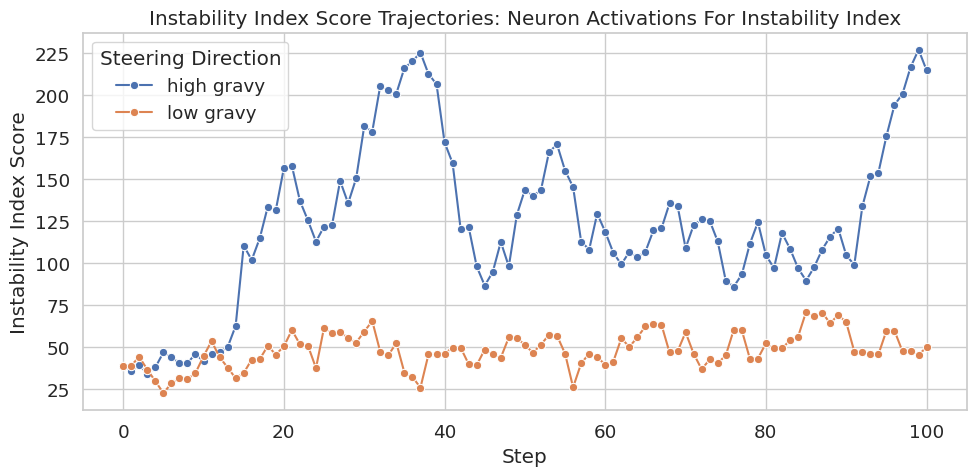

In [ ]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm3B_500k_neuron_explanations.csv"
MODEL_NAME = "facebook/esm2_t36_3B_UR50D"
SEQ_LEN = 200
NUM_STEPS = 100
A = 10
B = 3

# Utilities
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()



def steer(model, tokenizer, base_sequence, match_string, label=None):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    device = model.device
    history = []
    
    seq = base_sequence
    for step in tqdm(range(NUM_STEPS), desc=f"Steering for {label}"):
        masked_seq = list(seq)
        mask_indices = random.sample(range(len(seq)), len(seq)//4)  # Mask ~25% of positions
        
        for idx in mask_indices:
            masked_seq[idx] = tokenizer.mask_token
        
        masked_seq_str = ''.join(masked_seq)
        inputs = tokenizer(masked_seq_str, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        for h in handles:
            h.remove()

        new_seq = list(seq)
        for idx in mask_indices:
            token_logits = logits[idx + 1]  
            sampled_token_id = sample_from_logits(token_logits.unsqueeze(0))
            sampled_token_id = sampled_token_id.item()
            new_token = tokenizer.decode([sampled_token_id], skip_special_tokens=True)
            if new_token and new_token in "ACDEFGHIKLMNPQRSTVWY":
                new_seq[idx] = new_token
        
        seq = ''.join(new_seq)

        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        gravy = compute_gravy_ignore_x(seq)

        history.append((step + 1, seq, avg_act, gravy, label))

    return history


# Run both steering loops
if __name__ == "__main__":
    torch.manual_seed(42)
    random.seed(42)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
    model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
    model.eval()

    # Generate shared initial sequence
    base_sequence = random_protein_sequence(SEQ_LEN)
    print("Starting sequence:", base_sequence)

    # Run both steering directions
    history_pos = steer(model, tokenizer, base_sequence, "high gravy", label="low gravy")
    history_neg = steer(model, tokenizer, base_sequence, "low gravy", label="high gravy")
    # Add initial point (step 0) before steering
    initial_gravy = compute_gravy_ignore_x(base_sequence)
    init_row = (0, base_sequence, 0.0, initial_gravy, "high gravy")
    history_pos = [init_row] + history_pos
    init_row = (0, base_sequence, 0.0, initial_gravy, "low gravy")
    history_neg = [init_row] + history_neg

    # Save both to CSV
    with open("steered_sequences_dual.csv", "w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(["step", "sequence", "activation", "gravy", "label"])
        for row in history_pos + history_neg:
            writer.writerow(row)

    # Plot GRAVY score trajectories
    df = pd.DataFrame(history_pos + history_neg, columns=["step", "sequence", "activation", "gravy", "label"])
    sns.set(style="whitegrid", font_scale=1.2)
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=df, x="step", y="gravy", hue="label", marker="o")
    plt.xlabel("Step")
    plt.ylabel("Instability Index Score")
    plt.title("Instability Index Score Trajectories: Neuron Activations For Instability Index")
    plt.legend(title="Steering Direction")
    plt.tight_layout()
    plt.savefig("gravy_score_comparison.png")
    
    plt.show()


In [22]:
history_neg

[(0,
  'PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYVARQMGPDKLYVGMEWVGPPESMSMAHAWVTHCVWCLCSSDLMGVKFMRFHYPKMDFHNFFCPFWVCFQFDWNLSTECKKLRQYCKHVFEKKGFWKVNCYTYWTELFKCIYGSLKYYNREGYNMRCNMVEYCENQFDVFNPKNMWFRFIQGHSCLYYCFGWVVIETRPYQATGQWDDDNGPRFPGLWTCKGASPGRNKACV',
  0.0,
  35.17370000000001,
  'low instability indices'),
 (1,
  'PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYVARQMGPDKLYVGMEWVGWPESMSMAHAWVTHCVWCLCSSDLMGVKFMRFHYPKMDFHNFFCPFWVCFQFDWNLSTECKKLRVYCKHVFEKKGFWKVNCYTYWTELFKCIYGSLKYYNREGYNMRCNMVEYCENQFDVFNPKNMWFRFIQGHSCLYYPFGWVVIETRPYQATGFWDDDNGPRFPGLWRCKGASPGRNKACV',
  0.3430031060374209),
 (2,
  'PAGFRQVCKSFMAEPMFNTATFHEYHCCTPTRMYINWPVNRAFGCFDGPIIFGWPPEREIYPNQTSFAHGFWVHQIWLGFNGNVIFYMCADPSKCIYMYVARQMGPDKLYVGMEWVGWPESMSMAHAWVTHCVWCLCSSDLMGVKFMRFHYPKMDFHNFFCPFWVCFQFDWNLSTECKKLRVYCKHVFEKKGFWKVNCYTYWTELFKCIYGSLKYYNREGYNMFCNMVEYCENQFDVFNPKNMWFRFIQGHSCLYYPFGWVVIETRPYQATGFWDDDNGPRFPGLWRCK

In [17]:
import torch
import torch.nn.functional as F
from transformers import AutoModelForMaskedLM, AutoTokenizer
import random
import csv
import re
from collections import defaultdict
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from Bio.SeqUtils.ProtParam import ProteinAnalysis

# Configuration
CSV_PATH = "esm35M_500k_neuron_explanations.csv"
MODEL_NAME = "facebook/esm2_t12_35M_UR50D"
SEQ_LEN = 50
NUM_STEPS = 10
A = 1000
B = 100

# Utilities
def find_matching_neurons(csv_path, keyword):
    matches = []
    with open(csv_path, newline='') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) < 2:
                continue
            neuron_id = row[0]
            if any(keyword in desc.lower() for desc in row[1:]):
                m = re.match(r"layer_(\d+)_neuron_(\d+)", neuron_id)
                if m:
                    matches.append((int(m.group(1)), int(m.group(2))))
    return matches

def make_multi_neuron_hook(neurons, a=10.0, b=3.0):
    def hook_fn(module, input, output):
        for neuron in neurons:
            output[:, :, neuron] = a * output[:, :, neuron] + b
        return output
    return hook_fn

def random_protein_sequence(length):
    return ''.join(random.choices("ACDEFGHIKLMNPQRSTVWY", k=length))

def sample_from_logits(logits):
    probs = F.softmax(logits, dim=-1)
    return torch.multinomial(probs, num_samples=1).squeeze(-1)

def decode_tokens(tokenizer, token_ids):
    return tokenizer.decode(token_ids, skip_special_tokens=True).replace(" ", "")

def compute_gravy_ignore_x(seq):
    cleaned = seq.replace("X", "")
    if not cleaned:
        return None
    return ProteinAnalysis(cleaned).instability_index()

# Main steering function
def steer(model, tokenizer, base_sequence, match_string, label=None):
    matched_neurons = find_matching_neurons(CSV_PATH, match_string)
    if not matched_neurons:
        print(f"No matching neurons found for: {match_string}")
        return []

    layer_to_neurons = defaultdict(list)
    for layer, neuron in matched_neurons:
        layer_to_neurons[layer].append(neuron)

    device = model.device
    history = []  # (step, sequence, activation, gravy)

    seq = base_sequence
    for step in tqdm(range(NUM_STEPS), desc=f"Steering for {label}"):
        inputs = tokenizer(seq, return_tensors="pt").to(device)

        handles = []
        for layer, neurons in layer_to_neurons.items():
            hook = model.base_model.encoder.layer[layer].intermediate.register_forward_hook(
                make_multi_neuron_hook(neurons, A, B)
            )
            handles.append(hook)

        with torch.no_grad():
            outputs = model(**inputs, output_hidden_states=True)
            logits = outputs.logits[0]
            hidden_states = outputs.hidden_states

        for h in handles:
            h.remove()

        # Score: average absolute activation across target neurons
        total, count = 0, 0
        for layer, neurons in layer_to_neurons.items():
            h = hidden_states[layer][0]
            for n in neurons:
                total += abs(h[:, n].mean().item())
                count += 1
        avg_act = total / count if count > 0 else 0

        sampled_ids = sample_from_logits(logits)
        seq = decode_tokens(tokenizer, sampled_ids)
        history.append((step + 1, seq, avg_act))

    return history


torch.manual_seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, do_lower_case=False)
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# Generate shared initial sequence
base_sequence = random_protein_sequence(SEQ_LEN)
print("Starting sequence:", base_sequence)

# Run both steering directions
history_pos = steer(model, tokenizer, base_sequence, "sheet")

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForMaskedLM: ['esm.embeddings.position_embeddings.weight']
- This IS expected if you are initializing EsmForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Starting sequence: PAGFRQVCKAFMAEPMFNTATQHEYHCCTPTRMYINTPVNRAFGCFDGPI


Steering for None: 100%|██████████| 10/10 [00:05<00:00,  1.86it/s]


In [18]:
history_pos

[(1, 'WYSYYXYYYYCHFYCYXHCYCYFCLFCYCYSNYYRYCAXYRFYKYYYYSF', 823.5452444459212),
 (2, 'FWYCDYHYYYKMYYYYLYWYYYCLHWYYYHYYYRYYYYYYYMYYYYYYYNY', 735.6388845270043),
 (3,
  'YLNYLWYWYYYYLYYHYYYFYYHMYHYYYHHYYYYYYYYYYLYDYYLYYYMYY',
  770.1472303236417),
 (4,
  'MYYHHYMYYYYYYYYYMHYYYYYYMYYHYYYMYYYYYHYYYLYHYHYHRYMYYF',
  767.7199364950673),
 (5,
  'WYYYYYYMYYYYYYHYYYHYYYYYYMYYFYYYYYFLYWYYYYYHYYHYWYYYNWY',
  785.7665906985651),
 (6,
  'FWLYHYYHYYAMYYYWYYYLYHYYXYMHHYYYYXYXHRYYMNFYCYYYYHYYYPW',
  772.3924227845383),
 (7,
  'WYFYYWYYHYHWLYYYHYYYMYYYWYYYHYYYYYYWLWYYIWWYLYDYYWHYYFMM',
  771.1593857713774),
 (8,
  'MMYWHYMYYYYYYXYYYFYYYYYYMYHYYYYLYFYYYYYYMWMWYMYYYYYWYYYWYY',
  778.5953055039317),
 (9, 'FYMMYYQAYIYWYHYYYXYYYYHYYYYYMYYYYYYYYMCYYYLWHYHYHW', 760.0131597418416),
 (10, 'WYYPHYYMMYFYYFYHYYYYYMYCYYYMYYYYYLYYYYYYMLYYMYYWW', 767.5045485569487)]